In [1]:
%load_ext autoreload 
%autoreload 2
%load_ext rpy2.ipython

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [2]:
import pandas as pd
import data
from IPython.display import HTML, Markdown
import logisticRegression
import numpy as np
import Model
import Trackers.ModelTracker as ModelTracker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import plot_tools
import writing_tools
import FeatureTools
import Trackers.FeatureTracker as FeatureTracker
import Trackers.DataTracker as DataTracker
import math
import model_config

In [3]:
df = data.get_data()
data_info_instance = data.DataInfo.get_instance()
model_tracker = ModelTracker.ModelTracker()
data_tracker = DataTracker.X_tracker()
cols_to_scale = []

For the prediction task, the underlying problem is to the find the subset of customers with a probability of having a caravan insurance policy above some boundary probability. The known policyholders can then be removed and the rest receives a mailing. The boundary depends on the costs and benefits such as of the costs of mailing and benefit of selling insurance policies. To approximate this problem, we want you to find the set of 800 customers in the test set that contains the most caravan policy owners.

Le but est de maximiser le nombre d’individus avec CARAVAN = 1 parmi les 800 clients ayant les probabilités prédites les plus élevées.

$$\text{logit } p = \ln \frac{p}{1-p} = \beta_0 + \beta_1x_1 + ... + \beta_nx_n = z$$
$$ e^z = \frac{p}{1-p} \iff p = \frac{e^z}{1 + e^z} $$
$$p = P(\text{CARAVAN} = 1 | X = x)$$

$$\text{odds } = \frac{p}{1-p}$$

$$OR = e^{\beta}$$

Le odds-ratio permet de mesurer l'effet d'une variable sur la probabilité qu'un évenements se produise (CARAVAN = 1).

Il faut que je calcul l'intervalle de confiance pour assumer qu'une variable est significative selon la valeur de son $OR$.

Pour calculer un intervalle de confiance, j'ai besoin de l'écart-type des variables. Mais puisque OR dépend des rélations entres les variables, je dois utiliser une matrice de covariance, qui est l'inverse de la matrice de Fisher Information.

**Fisher Information :** 

$$\theta = \mathbb{E} \left[ \left( \frac{\partial}{\partial \theta} \log f(X; \theta) \right)^2 \right]$$

$\mathbb{E} = $  espérance de $X$ \
$f(X; \theta) = $ fonction de densité de $X$

Forme matrice : 

$$p_i = P(\text{CARAVAN} = 1 | X_i) = \sigma(X_i \cdot \beta) = \dfrac{e^{X_i \cdot \beta}}{1 + e^{X_i \cdot \beta}} $$
$$\ell(\beta) = \sum^n_{i=1} \log f(X_i; \theta) =  \sum_{i=1}^{n} \Big[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \Big] = - \text{cost function }$$
$$(y_i = \text{la valeur observée du target (0 ou 1))}$$
$$
\frac{\partial \ell}{\partial \beta} = X^T (y - p) = \text{gradient ascent} \\
\frac{\partial^2 \ell}{\partial \beta\, \partial \beta^T} = -X^T W X = \text{variation du gradient ascent}
$$

$$\text y_i \sim Bernoulli(p) \iff Var(y_i) = p_i(1 - p_i)$$

$$ W = diag(p_i(1 - p_i)) = Var(Y) =
\begin{bmatrix}
p_1(1-p_1) & 0 & \cdots & 0 \\
0 & p_2(1-p_2) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & p_n(1-p_n)
\end{bmatrix}$$

Sa calcul la précision de l'estimation d'un coefficient 


In [4]:
categorical_non_ordinales = ['MOSTYPE', 'MOSHOOFD']
df_encoded = pd.get_dummies(df, columns=categorical_non_ordinales, prefix=categorical_non_ordinales, dtype=int, drop_first=True)
X_base_one_hot = df_encoded.copy()
feature_tracker = FeatureTracker.FeatureTracker(X_base_one_hot)
X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(to_np=True)

model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[914 181]
 [ 33  37]]


In [5]:
coeff = model.w
bias = model.b
odds_ratio = np.exp(coeff)
confiance = 0.95

def fisher_info(X, w, b):
    z = X @ w + b
    p = logisticRegression.sigmoid(z)
    W = np.diag(p * (1-p))
    fi = X.T @ W @ X
    return fi

fi = fisher_info(X_train_np, coeff, bias)
print(np.linalg.det(fi))

4.753692681997185e-11


La matrice de covariance est proche d'être singuliaire, car $\text{det}(\text{fisher\_information}) \approx 0$, elle est presque non-inversible. \
Si je l'inverse, il y a des variances gigantesque et positive/négative.

- Si on regarde qu'elle variance $\lt$ 0, on trouve que 14 d'entres elles sont négatives (elles sont aussi gigantesques) $( Var(y) \lt -10^{14})$. \
29 sont des variables catégoriques non-ordinales à propos du type de cients et 2 sont à propos du nombre et la contribution d'assurance surfboard. \

- Si on regarde ceux qui sont géante, on trouve qu'il y en a 32 d'entres elles qui sont gigantesques.


C'est un signe que ces variables sont peut-être complètement séparer des données, donc pourait prédire constamment le même résultat, ce qui indique que leur $\beta$ tend vers $\pm \infin$.

In [6]:
cov_matrix = np.linalg.inv(fi)
#std = np.sqrt(np.diag(cov_matrix))
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'var': np.diag(cov_matrix),
})

print('négatif count in variance:               ', coef_df[coef_df['var'] < 0].shape[0])
print('négatif gigantesque count in variance:   ', coef_df[coef_df['var'] <= -10**13].shape[0])
print('Gigantesque count in variance:           ', coef_df[coef_df['var'] >= 10**(14)].shape[0])

huge_neg_coeff_cols = coef_df[coef_df['var'] < 0]['feature'].values
huge_pos_coeff_cols = coef_df[coef_df['var'] >= 10**(14)]['feature'].values

inf_coef_cols = np.concatenate((huge_neg_coeff_cols, huge_pos_coeff_cols), axis=0)
X_train_inf_coef = X_train[inf_coef_cols].copy()

négatif count in variance:                14
négatif gigantesque count in variance:    14
Gigantesque count in variance:            32


Si on vérifie, on trouve qu'il y a quelque une variable qui prédit toujours CARAVAN = 0 et le reste sont des cas très rares.

In [7]:
huge_neg_coeff_cols = coef_df[coef_df['var'] < 0]['feature'].values
huge_pos_coeff_cols = coef_df[coef_df['var'] >= 10**(14)]['feature'].values

inf_coef_cols = np.concatenate((huge_neg_coeff_cols, huge_pos_coeff_cols), axis=0)
X_train_inf_coef = X_train[inf_coef_cols].copy()

cols_with_zeros_targets = []
cols_with_all_targets = []
cols_with_rare_outcomes = {}

for c in inf_coef_cols:
    crossTab = pd.crosstab(X_train_inf_coef[c], y_train)

    if 1 in crossTab.index:
        #print(f'\n{c} = 1')
        not_target_count = crossTab.loc[1, 0]
        target_count = crossTab.loc[1, 1]
        #print(f"    (CARAVAN=0) : {not_target_count}")

        if target_count == 0:
            #print(f'    Prédit toujours CARAVAN=0')
            cols_with_zeros_targets.append(c)
        elif not_target_count == 0:
            #print(f'    Prédit toujours CARAVAN=1')
            cols_with_all_targets.append(c)
        else:
           #print(f"    (CARAVAN=1): {target_count}")
           cols_with_rare_outcomes[c] = np.array([target_count, not_target_count])
    else:
        print('what?')

Les variables qui prédisent tous le temps CARAVAN = 0 dans le training set sont inutiles donc je vais les retirer.

In [8]:
feature_tracker.remove_list(cols_with_zeros_targets)
X = feature_tracker.flush_to_df()

X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(to_np=True)

Les autres variables ne sont pas complètement séparer, mais peut-etre souffre de multicolinéarité, ce qui serait la cause de leur variance gigantesque.

Précédemment, j'avais utilisé une matrice de corrélation pour trouver les corrélations entre variables, mais le problème est qu'elle évalue seulement la colinéarité entre deux variables. Pour ce problème, c'est mieux d'utiliser le VIF, car il permet d'analyser l'impact de tout les autres variables sur la variance d'un coefficient, ce qui est exactement ce que j'ai besoin pour trouver la cause de la variance énorme des variables restantes. 

$$VIF = \dfrac{1}{1-R^2}$$
$$
X_i = \beta_0 + \sum_{j \neq i}(\beta_j X_j) + \varepsilon_i \\
\hat{\beta} = (X^TX)^{-1}X^Ty 
$$
$$\varepsilon_i = X_i -\hat{X_i} \iff Var(\varepsilon_i) = Var(X_i) -Var(\hat{X_i})$$
$$\sum{\varepsilon_i} = \sum{(X_i -\hat{X_i})} = 0$$
$$
R^{2}_{i} = \frac{Var(\hat{X_i})}{Var(X_i)} = \frac{ Var({X_i}) - Var(\varepsilon_i)}{Var(X_i)} 
= 1 - \frac{Var(\varepsilon_i)}{Var({X_i})}
$$

In [9]:
def ols(X, y):
    w = np.linalg.lstsq(X, y, rcond=None)[0]
    return w

def regressionLineaire(X, y):
    w = ols(X, y)
    residual = y - X @ w
    return w, residual

def auxRegLin(X, eps, tol=1e-12):
    var_residual = np.sum(eps**2)
    xm = np.mean(X)
    var_X = np.sum((X - xm)**2)
    if var_X <= tol: return 0
    return (1 - var_residual/var_X)
    
def vif(X, cols):
    vif_res = {}
    for c in cols:
        X_i = X[c].to_numpy()
        X_hat_i = X.drop(c, axis=1).to_numpy()
        X_hat = np.column_stack([np.ones(len(X_i)), X_hat_i])
        w, residu = regressionLineaire(X_hat, X_i)
        R2 = auxRegLin(X_i, residu)
        vif = np.inf if np.isclose(1 - R2, 0) else 1 / (1 - R2)
        vif_res[c] = vif
    return pd.DataFrame.from_dict(vif_res, orient='index', columns=['VIF']).sort_values(by='VIF', ascending=False)

df_vif = vif(X.drop('CARAVAN', axis=1), cols_with_rare_outcomes)

In [10]:
index_mid_corr = df_vif[(df_vif['VIF'] > 1) & (df_vif['VIF'] <= 5)].index
index_high_corr = df_vif[(df_vif['VIF'] > 5) & (df_vif['VIF'] <= 10)].index
index_serious_corr = df_vif[(df_vif['VIF'] > 10)].index

Tout les variables avec un $R^2$ = $\inf$ (colinéarité parfaite, donc parfaitement prédite par les autres variables) sont des variables de types MOSTYPE (customer sub-type) ou MOSHOOFD (customer main type). Je vais les retirer puisqu'elle n'aide pas le modèle. Les seules que je vais garder sont eux avec 1 < VIF < 5. Plus grand leur résultat VIF indique qu'ils sont hautement corrélés.

Les métriques restent similaires à avant le retrait de ces variables, donc c'est une confirmation que le retrait n'a pas tellement affecté les prédictions du modèles.

In [11]:
feature_tracker.remove_list(index_high_corr)
feature_tracker.remove_list(index_serious_corr)

X = feature_tracker.flush_to_df()

model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[913 182]
 [ 33  37]]


Maintenant, on retourne au calcul de Fisher information pour trouver les variables les plus utiles pour prédire CARAVAN=1

In [12]:
X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(to_np=True)
fi = FeatureTools.fisher_info(X_train_np, model.w, model.b)
print(np.linalg.det(fi))

-1.615584458150003e+94


In [13]:
eigen_values = np.linalg.eigvals(fi)
print('Nombre de eigen values négative: ', (eigen_values<0).sum())

Nombre de eigen values négative:  1


In [14]:
eigen_values, eigen_vectors = np.linalg.eig(fi)
negative_values = (eigen_values<0)
idx_problem = [i for i, is_negative in enumerate(negative_values) if is_negative]

problematic_vector = eigen_vectors[:, idx_problem]

index = X.drop('CARAVAN', axis=1).columns

problematic_variables_df = pd.DataFrame(np.abs(problematic_vector), index=index)
Markdown(problematic_variables_df.sort_values(by=0, ascending=False).head().to_markdown())


|         |           0 |
|:--------|------------:|
| PZEILPL | 0.707107    |
| AZEILPL | 0.707107    |
| AGEZONG | 4.77456e-15 |
| AVRAAUT | 2.33458e-15 |
| PGEZONG | 1.97732e-15 |

Seulement une personne dans le training set a PZEILPL ou AZEILPL > 0 et CARAVAN = 1

In [15]:
Markdown(FeatureTools.get_target_count_of_variables(X_train, y_train, ['PZEILPL', 'AZEILPL']))

|    |   PZEILPL (CARAVAN=1) |   AZEILPL (CARAVAN=1) |
|---:|----------------------:|----------------------:|
|  0 |                   277 |                   277 |
|  1 |                     1 |                     1 |

Parfait, maintenant le determinant n'est plus négatif

In [16]:
feature_tracker.remove_list(['PZEILPL', 'AZEILPL'])
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model(print_stats=False)

X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(to_np=True)
fi = FeatureTools.fisher_info(X_train_np, model.w, model.b)
print(np.linalg.det(fi))

9.848675513629938e+128


In [17]:
import scipy.stats as st

coeff = model.w 
bias = model.b 
odds_ratio = np.exp(coeff) 
confiance = 0.95

X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(to_np=True)

fi = FeatureTools.fisher_info(X_train_np, model.w, model.b)
cov_matrix = np.linalg.inv(fi)
std = np.sqrt(np.diag(cov_matrix))

surface = 1 - (1-confiance)/2
z = st.norm.ppf(surface)

bi = coeff - z * std
bs = coeff + z * std

bi_or = np.exp(bi)
bs_or = np.exp(bs)
    
coef_df = pd.DataFrame({
    'feature': X.drop('CARAVAN', axis=1).columns,
    '$\\beta_n$': model.w,
    '$OR$': odds_ratio,
    '$bi_{OR}$': bi_or,
    '$bs_{OR}$': bs_or
})

coef_df = coef_df.round(4)

mask_signif = (coef_df['$bi_{OR}$'] > 1) | (coef_df['$bs_{OR}$'] < 1)
Markdown(coef_df[mask_signif].to_markdown())

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 44 | PPERSAUT  |      0.1974 | 1.2182 |      1.1104 |      1.3365 |

$$OR > 1 \to \text{augmente les chances que CARAVAN = 1}$$
$$OR < 1 \to \text{diminue les chances que CARAVAN = 1}$$
$$OR = 1 \to \text{aucun effet sur les chances que CARAVAN = 1}$$

Présentement, voici à quoi ressemble le modèle sans aucune variable additionnel.

In [18]:
X = feature_tracker.flush_to_df()

In [19]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
cols = df_vif[df_vif['VIF'] >= 10].index
cols.sort_values()

Index(['AAANHANG', 'ABROM', 'ABYSTAND', 'AGEZONG', 'AMOTSCO', 'AVRAAUT',
       'AWALAND', 'AWAOREG', 'AWAPART', 'AWERKT', 'MAUT0', 'MAUT1', 'MFALLEEN',
       'MFGEKIND', 'MFWEKIND', 'MGODPR', 'MHHUUR', 'MHKOOP', 'MINK4575',
       'MINKM30', 'MOPLHOOG', 'MOPLLAAG', 'MOPLMIDD', 'MRELGE', 'MRELOV',
       'MSKC', 'MZFONDS', 'MZPART', 'PAANHANG', 'PBROM', 'PBYSTAND', 'PGEZONG',
       'PMOTSCO', 'PTRACTOR', 'PVRAAUT', 'PWALAND', 'PWAOREG', 'PWAPART'],
      dtype='object')

Tout les variables qui débute par A sont des variables qui indique le nombre de police d'assurance x.
Je vais tout les regrouper en une seule variable 'total' puisqu'elle mesure la meme chose que les variables P mais sous une différentes unité. (Nombre de polices vs Contribution). 

| Type d'assurance                          | Variables associées | Description complète |
|------------------------------------------|-------------------|--------------------|
| Assurance vie / accidents / santé         | ALEVEN, APERSONG, AGEZONG, AWAOREG, ABRAND, ABYSTAND | Number of life insurances, private accident insurance policies, family accidents insurance policies, disability insurance policies, fire policies, social security insurance policies |
| Third party insurance                     | AWAPART, AWABEDR, AWALAND | Private third party insurance, third party insurance (firms), third party insurance (agriculture) |
| Assurance véhicule quotidien              | APERSAUT, AMOTSCO, ABROM | Number of car policies, motorcycle/scooter policies, moped policies |
| Assurance véhicule de travail / poids lourd | AVRAAUT, ATRACTOR, AWERKT, AAANHANG, ABESAUT | Number of lorry, tractor, agricultural machines, trailer policies, delivery van policies |
| Assurance propriété                       | AINBOED           | Number of property insurance policies |
| Assurance véhicule de loisir              | APLEZIER, AFIETS, AZEILPL | Number of boat, bicycle, surfboard policies |





In [20]:
print('|----- Avant le regroupement -----|')
model = feature_tracker.get_trained_model()

|----- Avant le regroupement -----|
Threshold   : 0.1000
[[913 182]
 [ 33  37]]


In [21]:
feature_tracker.restore('AZEILPL') # car retirer précédemment
X = feature_tracker.flush_to_df()

life_accidents_health = np.array(['ALEVEN','APERSONG','AGEZONG','AWAOREG','ABRAND','ABYSTAND'])
third_party_insurance = np.array(['AWAPART','AWABEDR','AWALAND'])
daily_vehicle = np.array(['APERSAUT','AMOTSCO','ABROM'])
work_heavy_vehicle = np.array(['AVRAAUT','ATRACTOR','AWERKT','AAANHANG','ABESAUT'])
property_insurance = np.array(['AINBOED'])
leisure_vehicle = np.array(['APLEZIER','AFIETS','AZEILPL'])

all_policies = np.concatenate([life_accidents_health, third_party_insurance, daily_vehicle, work_heavy_vehicle, property_insurance, leisure_vehicle])

feature_tracker.add('total_policies', X[all_policies].sum(axis=1), toScale=True)
feature_tracker.remove_list(all_policies)
X = feature_tracker.flush_to_df()

print('|----- Après le regroupement -----|')
model = feature_tracker.get_trained_model()

|----- Après le regroupement -----|
Threshold   : 0.1000
[[914 181]
 [ 32  38]]


In [22]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
df_vif[df_vif['VIF'] >= 10]

,VIF
MHHUUR,1607.413278
MHKOOP,1605.011609
MZFONDS,802.201002
MZPART,801.486528
MOPLLAAG,31.976265
MRELGE,22.988768
MFWEKIND,21.727982
MRELOV,18.949109
MOPLMIDD,18.107363
MFALLEEN,15.636070


(Rented house) MHHUUR $\iff$ MHKOOP (Home owner) \
(National Health Service) MZFONDS $\iff$ MZPART (Private health insurance)

MOPLLAAG - MOPLMIDD - MOPLHOOG (retire une, devient catégorie de référence)

MRELGE - MRELOV - MRELSA (retire une, devient catégorie de référence) (MRELOV, car plus facile a interpreter apres, marier ou habite ensemble ou sinon catégorie de référence aka other relation)

MFWEKIND - MFGEKIND - MFALLEEN (meme chose que ^) (MFGEKIND)

MAUT0 - MAUT1 - MAUT2 (mm chose) (MAUT0)

MINK* (mm chose) (MINKM30)

MGOD* (mm chose) (MGODOV)

MBER* (mm chose) (MBERARBO)

In [23]:
feature_tracker.remove_list(['MHHUUR', 'MZFONDS', 'MOPLLAAG', 'MRELOV', 'MFGEKIND', 'MAUT0', 'MINKM30', 'MGODOV', 'MBERARBO'])
X = feature_tracker.flush_to_df()

In [24]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
Markdown(df_vif[df_vif['VIF'] >= 5].to_markdown())

|                |     VIF |
|:---------------|--------:|
| total_policies | 9.87819 |
| MSKA           | 8.15507 |
| MSKC           | 7.76223 |

Pour le reste des variables, je vais utiliser le score Z pour voir si elle sont significative ou pas.

$$H_0 : w_i = 0$$
$$H_1 : w_i \neq 0$$

In [25]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
model = feature_tracker.get_trained_model(print_stats=False)

Elles contiennent tous $0$, il y a la possibilité que l'effet de ces variables soit nul.

In [26]:
fi = FeatureTools.fisher_info(X_train.to_numpy(), model.w, model.b)
cov_matrix = np.linalg.inv(fi)
std = np.sqrt(np.diag(cov_matrix))

z_scores = model.w / std

z_scores_df = pd.DataFrame({
    'Variable': X_train.columns,
    '$w_i$': model.w,
    r'$\sigma$': std,
    '$Z$': abs(z_scores)
})

z_scores_df['$b_i$'] = z_scores_df['$w_i$'] - 1.96 * z_scores_df[r'$\sigma$']
z_scores_df['$b_s$'] = z_scores_df['$w_i$'] + 1.96 * z_scores_df[r'$\sigma$']

vars = ['total_policies', 'MSKA', 'MSKC']

Markdown(z_scores_df[z_scores_df['Variable'].isin(vars)].to_markdown())

|    | Variable       |      $w_i$ |   $\sigma$ |      $Z$ |     $b_i$ |     $b_s$ |
|---:|:---------------|-----------:|-----------:|---------:|----------:|----------:|
| 17 | MSKA           | -0.0337001 |  0.0982806 | 0.342896 | -0.22633  | 0.15893   |
| 20 | MSKC           | -0.109832  |  0.0758362 | 1.44828  | -0.258471 | 0.0388066 |
| 60 | total_policies |  0.102733  |  0.169785  | 0.605078 | -0.230046 | 0.435512  |

Le coefficient de la variable PFIETS de total_policies est le plus élevé. Un client avec une assurance vélo a tendance à avoir beaucoup plus de polices au total.

In [27]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols, return_coef=True)
Markdown(df_vif[df_vif['Target'] == 'total_policies'].sort_values(by='coef', key=abs, ascending=False).head().to_markdown())

|      | Target         | Variable   |      coef |
|-----:|:---------------|:-----------|----------:|
| 3660 | total_policies | Intercept  | -1.21704  |
| 3710 | total_policies | PFIETS     |  0.882518 |
| 3700 | total_policies | PAANHANG   |  0.517393 |
| 3693 | total_policies | PWAPART    |  0.410282 |
| 3702 | total_policies | PWERKT     |  0.388062 |

Mais dans le training set, seulement 11/278 $\approx$ 3.96% des targets ont une contribution plus grande que 0 pour PFIETS (Contribution bicycle policies).

In [28]:
X_train[y_train == 1][['PFIETS']].value_counts().sort_index()

PFIETS
0         267
1          11
Name: count, dtype: int64

In [29]:
vars = ['total_policies', 'MSKA', 'MSKC']
feature_tracker.remove_list(vars)
X = feature_tracker.flush_to_df()

X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 5].to_markdown())

| VIF   |
|-------|


Les variables significatives sont 

In [30]:
model = feature_tracker.get_trained_model(print_stats=False)
Markdown(FeatureTools.or_with_ic(model, X_train.to_numpy(), X_train.columns))

|    | feature                            |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:-----------------------------------|------------:|-------:|------------:|------------:|
| 33 | PPERSAUT_Contribution_car_policies |      0.1848 | 1.203  |      1.1456 |      1.2633 |
| 45 | PBRAND_Contribution_fire_policies  |      0.0925 | 1.0969 |      1.0076 |      1.194  |
| 16 | MBERARBG_Skilled_labourers         |     -0.1017 | 0.9033 |      0.8182 |      0.9973 |
|  4 | MGODPR_Protestant_...              |     -0.1219 | 0.8852 |      0.7894 |      0.9928 |
|  8 | MFALLEEN_Singles                   |     -0.1654 | 0.8476 |      0.7584 |      0.9472 |
|  5 | MGODGE_No_religion                 |     -0.1766 | 0.8382 |      0.7456 |      0.9423 |

Au lieu d'utiliser total_policies, je vais voir si des total thématiques sont mieux. total_policies était trop corrélée.

In [31]:
print('|----- Sans ajout -----|')
model = feature_tracker.get_trained_model()

|----- Sans ajout -----|
Threshold   : 0.1000
[[926 169]
 [ 33  37]]


In [32]:
feature_tracker.restore('AZEILPL') # car retirer précédemment

life_accidents_health = np.array(['ALEVEN','APERSONG','AGEZONG','AWAOREG','ABRAND','ABYSTAND'])
third_party_insurance = np.array(['AWAPART','AWABEDR','AWALAND'])
daily_vehicle = np.array(['APERSAUT','AMOTSCO','ABROM'])
work_heavy_vehicle = np.array(['AVRAAUT','ATRACTOR','AWERKT','AAANHANG','ABESAUT'])
property_insurance = np.array(['AINBOED'])
leisure_vehicle = np.array(['APLEZIER','AFIETS','AZEILPL'])

all_policies = np.concatenate([life_accidents_health, third_party_insurance, daily_vehicle, work_heavy_vehicle, property_insurance, leisure_vehicle])
feature_tracker.restore_list(all_policies)
X = feature_tracker.flush_to_df()

feature_tracker.add('total_life_health_policies', X[life_accidents_health].sum(axis=1), toScale=True)
feature_tracker.add('total_third_party_policies', X[third_party_insurance].sum(axis=1), toScale=True)
feature_tracker.add('total_daily_vehicle_policies', X[daily_vehicle].sum(axis=1), toScale=True)
feature_tracker.add('total_work_heavy_vehicle_policies', X[work_heavy_vehicle].sum(axis=1), toScale=True)
feature_tracker.add('total_property_policies', X[property_insurance].sum(axis=1), toScale=True)
feature_tracker.add('total_leisure_vehicle_policies', X[leisure_vehicle].sum(axis=1), toScale=True)

feature_tracker.remove_list(all_policies)
X = feature_tracker.flush_to_df()

print('|----- Après le regroupement -----|')
model = feature_tracker.get_trained_model()

|----- Après le regroupement -----|
Threshold   : 0.1000
[[923 172]
 [ 32  38]]


In [33]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
Markdown(df_vif[df_vif['VIF'] >= 5].to_markdown())

|                                   |      VIF |
|:----------------------------------|---------:|
| total_third_party_policies        | 20.7014  |
| PWAPART                           | 19.619   |
| total_work_heavy_vehicle_policies | 11.0279  |
| total_leisure_vehicle_policies    |  7.39488 |
| total_daily_vehicle_policies      |  7.33684 |
| PFIETS                            |  6.49889 |
| PPERSAUT                          |  6.20111 |
| total_life_health_policies        |  5.21299 |

In [34]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval(to_scale=False)
total_vars = ['total_third_party_policies', 'PWAPART']
Markdown(FeatureTools.get_target_count_of_variables(X_train, y_train, total_vars))

|    |   total_third_party_policies (CARAVAN=1) |   PWAPART (CARAVAN=1) |
|---:|-----------------------------------------:|----------------------:|
|  0 |                                      116 |                   120 |
|  1 |                                      162 |                     6 |
|  2 |                                        0 |                   150 |
|  3 |                                        0 |                     2 |

Si total_third_party_policies == 1, alors PWAPART est majoritairement 2. 
- $\frac{150}{162} \approx 0.926$

Si total_third_party_policies == 0, alors PWAPART est majoritairement 0. 
- $\frac{116}{116} = 1$

PWAPART prédit déja majoritairement total_third_party_policies et cela fais du sens puisque PWAPART = Contribution private third party insurance. Donc je vais retirer total_third_party_policies puisqu'elle est redondante.

In [35]:
print(X_train.loc[(y_train == 1) & (X_train['total_third_party_policies'] == 0 ),'PWAPART'].value_counts())
print(X_train.loc[(y_train == 1) & (X_train['total_third_party_policies'] == 1 ),'PWAPART'].value_counts())

PWAPART
0    116
Name: count, dtype: int64
PWAPART
2    150
1      6
0      4
3      2
Name: count, dtype: int64


In [36]:
feature_tracker.remove('total_third_party_policies')
X = feature_tracker.flush_to_df()

In [37]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval(to_scale=False)

total_vars = ['total_life_health_policies', 'total_daily_vehicle_policies', 'total_work_heavy_vehicle_policies', 'total_leisure_vehicle_policies']

Markdown(FeatureTools.get_target_count_of_variables(X_train, y_train, total_vars))

|    |   total_life_health_policies (CARAVAN=1) |   total_daily_vehicle_policies (CARAVAN=1) |   total_work_heavy_vehicle_policies (CARAVAN=1) |   total_leisure_vehicle_policies (CARAVAN=1) |
|---:|-----------------------------------------:|-------------------------------------------:|------------------------------------------------:|---------------------------------------------:|
|  0 |                                       87 |                                         61 |                                             269 |                                          255 |
|  1 |                                      153 |                                        174 |                                               8 |                                           17 |
|  2 |                                       24 |                                         39 |                                               1 |                                            5 |
|  3 |                                        8 |                                          3 |                                               0 |                                            1 |
|  4 |                                        3 |                                          1 |                                               0 |                                            0 |
|  5 |                                        3 |                                          0 |                                               0 |                                            0 |

Seulement trois targets dans le training set ont une police de propriété. Je vais la jumeler a total_life_health_policies pour former total_life_policies.

Similairement pour total_work_heavy_vehicle_policies, seulement 9 des targets ont au moins une police de cette catégorie. Pareil pour total_leisure_vehicle_policies, seulement 23 sur 278. Je vais fusionner total_work_heavy_vehicle_policies à total_daily_vehicle_policies et total_leisure_vehicle_policies pour former total_vehicle_policies.



In [38]:
X_train.loc[y_train == 1, 'total_property_policies'].value_counts()

total_property_policies
0    275
1      3
Name: count, dtype: int64

In [39]:
feature_tracker.add('total_life_policies', X['total_property_policies'] + X['total_life_health_policies'], toScale=True)
feature_tracker.add('total_vehicle_policies', X['total_work_heavy_vehicle_policies'] + X['total_daily_vehicle_policies'] + X['total_leisure_vehicle_policies'], toScale=True)
feature_tracker.remove_list(['total_property_policies', 'total_life_health_policies', 'total_work_heavy_vehicle_policies', 'total_daily_vehicle_policies', 'total_leisure_vehicle_policies'])
X = feature_tracker.flush_to_df()

In [40]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
Markdown(df_vif[df_vif['VIF'] >= 5].to_markdown())

|                        |     VIF |
|:-----------------------|--------:|
| total_vehicle_policies | 8.80815 |
| total_life_policies    | 5.22103 |
| PPERSAUT               | 5.00302 |

Finalement, elles sont tous redondantes...

In [41]:
feature_tracker.remove_list(['total_life_policies', 'total_vehicle_policies'])
X = feature_tracker.flush_to_df()

In [42]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
model = feature_tracker.get_trained_model(print_stats=False)
Markdown(FeatureTools.or_with_ic(model, X_train.to_numpy(), X_train.columns))

|    | feature                            |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:-----------------------------------|------------:|-------:|------------:|------------:|
| 33 | PPERSAUT_Contribution_car_policies |      0.1848 | 1.203  |      1.1456 |      1.2633 |
| 45 | PBRAND_Contribution_fire_policies  |      0.0925 | 1.0969 |      1.0076 |      1.194  |
| 16 | MBERARBG_Skilled_labourers         |     -0.1017 | 0.9033 |      0.8182 |      0.9973 |
|  4 | MGODPR_Protestant_...              |     -0.1219 | 0.8852 |      0.7894 |      0.9928 |
|  8 | MFALLEEN_Singles                   |     -0.1654 | 0.8476 |      0.7584 |      0.9472 |
|  5 | MGODGE_No_religion                 |     -0.1766 | 0.8382 |      0.7456 |      0.9423 |

In [43]:
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[926 169]
 [ 33  37]]


Maintenant que le modèle est simplifier, je vais commencer a ajouter des nouvelles variables.

En testant des combinaisons différentes j'ai trouver ceci : si au lieu d'utiliser MINKM30 comme catégorie de référence j'utilise MINKM3045. Je garde le VIF de tout les variables en bas de 5 et MINKM30 devient une variable significative avec un OR < 1.

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 53 | MINKM30   |     -0.1384 | 0.8707 |      0.7908 |      0.9587 |

In [44]:
income_vars = [
    'MINKM30',
    #'MINK3045',
    'MINK4575',
    'MINK7512',
    'MINK123M',
    'MINKGEM'
]

feature_tracker.remove('avg_area_income')
feature_tracker.restore_list(income_vars)
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model(print_stats=False)

X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()

Markdown(FeatureTools.or_with_ic(model, X_train.to_numpy(), X_train.columns))

|    | feature                            |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:-----------------------------------|------------:|-------:|------------:|------------:|
| 33 | PPERSAUT_Contribution_car_policies |      0.1895 | 1.2087 |      1.1502 |      1.2701 |
| 45 | PBRAND_Contribution_fire_policies  |      0.0955 | 1.1002 |      1.01   |      1.1985 |
|  5 | MGODGE_No_religion                 |     -0.144  | 0.8659 |      0.7621 |      0.9837 |
| 58 | MINKM30_Income_<_30.000            |     -0.1612 | 0.8511 |      0.7305 |      0.9916 |

In [45]:
feature_tracker.restore('MINKM30')
feature_tracker.restore('MINK3045')
X = feature_tracker.flush_to_df()

income_brackets_midpoints = {
    'MINKM30': 15000,    
    'MINK3045': 37500,   
    'MINK4575': 60000,   
    'MINK7512': 98500,   
    'MINK123M': 180000 
}

income_cols = list(income_brackets_midpoints.keys())
weighted_somme = 0
for col in income_cols:
    weighted_somme += X[col] * income_brackets_midpoints[col]
total = X[income_cols].sum(axis=1)

for c in income_cols:
    feature_tracker.remove(c)
feature_tracker.remove('MINKGEM')

feature_tracker.add('avg_area_income',  weighted_somme / total, toScale=True)

X = feature_tracker.flush_to_df()

In [46]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
Markdown(df_vif[df_vif['VIF'] >= 5].to_markdown())

| VIF   |
|-------|

In [47]:
model = feature_tracker.get_trained_model(print_stats=False)
Markdown(FeatureTools.or_with_ic(model, X_train.to_numpy(), X_train.columns))

|    | feature                            |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:-----------------------------------|------------:|-------:|------------:|------------:|
| 28 | PPERSAUT_Contribution_car_policies |      0.1829 | 1.2007 |      1.1436 |      1.2607 |
| 40 | PBRAND_Contribution_fire_policies  |      0.0912 | 1.0955 |      1.0063 |      1.1925 |
| 16 | MBERARBG_Skilled_labourers         |     -0.1041 | 0.9012 |      0.8162 |      0.995  |
|  4 | MGODPR_Protestant_...              |     -0.1271 | 0.8806 |      0.7848 |      0.9882 |
|  8 | MFALLEEN_Singles                   |     -0.1623 | 0.8502 |      0.7597 |      0.9515 |
|  5 | MGODGE_No_religion                 |     -0.1825 | 0.8332 |      0.7417 |      0.9359 |

Maintenant concernant la variable MINKM30 (income < 30,000). On peut voir que quelqu'un qui habite dans un endroit avec bas income est moins probable d'avoir une assurance Caravan.

$$P(\text{avg\_area\_income} < 30000 \mid \text{CARAVAN} = 1) \approx 0.0312$$

In [48]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval(to_scale=False)
df_train = X_train.copy()
df_train['CARAVAN'] = y_train.copy()

print(df_train.loc[df_train['avg_area_income'] < 30000, 'CARAVAN'].mean().round(4))

0.0312


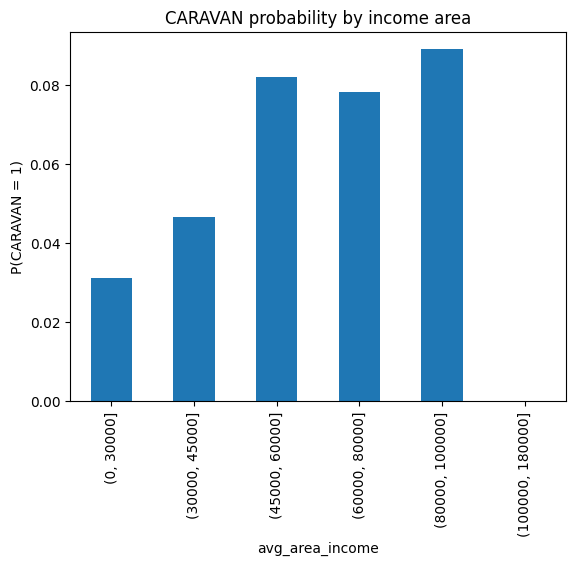

In [49]:
bins = [0, 30000, 45000, 60000, 80000, 100000, 180000]
df_income_bins = pd.DataFrame({
    'income_bin': pd.cut(X_train['avg_area_income'], bins=bins),
    'CARAVAN': y_train
})

rate_bin = df_income_bins.groupby('income_bin', observed=True)['CARAVAN'].mean()

ax = rate_bin.plot(kind='bar')
ax.set_xlabel("avg_area_income")
ax.set_ylabel("P(CARAVAN = 1)")
ax.set_title("CARAVAN probability by income area");

In [50]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()

features_significatifs = ["PPERSAUT", "PBRAND", "MBERARBG", "MGODPR", "MFALLEEN", "MGODGE"]

other_vars = ['avg_area_income']

X_train_sel = X_train[features_significatifs]
X_val_sel = X_val[features_significatifs]

print('|----- Avec tout les variables (VIF < 5) -----|')
model = feature_tracker.get_trained_model()
print()

print('|----- Seulement les variables significatives -----|')
model_var_signif_only = Model.create_model(X_train_sel.to_numpy(), y_train.to_numpy(), X_val_sel.to_numpy(), y_val.to_numpy(), learning_rate=0.01, threshold=0.1)
model_var_signif_only.print_val_stats()

|----- Avec tout les variables (VIF < 5) -----|
Threshold   : 0.1000
[[913 182]
 [ 33  37]]

|----- Seulement les variables significatives -----|
Threshold   : 0.1000
[[923 172]
 [ 39  31]]


En regardant la projection PCA des FN et TP seulement, on voit une séparation selon PC1. Les TP sont majoritairement à droite, FN plus à gauche.


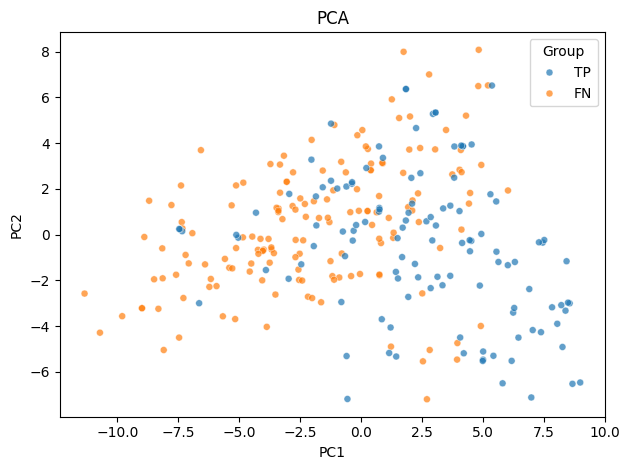

In [51]:
model = feature_tracker.get_trained_model(print_stats=False)
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=model.threshold, raw=True)
num_cols, cat_cols = feature_tracker.get_num_cat_cols()
df_loadings_pca_1 = plot_tools.plot_PCA(cat_cols, num_cols, df_profiles, TP_FN=True)

df_tp = df_profiles[df_profiles["Group"] == "TP"].copy()
df_fn = df_profiles[df_profiles["Group"] == "FN"].copy()

Mais, utiliser PCA dans mon cas peut etre une erreur.

PCA :

La matrice de covariance d'un échantillon : 

$$\mathbf{X} =  \begin{bmatrix}
\mathbf{x}_1 - \mathbf{\bar{x}}, \ldots, \mathbf{x}_n - \mathbf{\bar{x}}
\end{bmatrix}^\top
$$

$$\mathbf{S} = \frac{1}{n - 1} \mathbf{X}^\top \mathbf{X}$$

$$\mathbf{S} \propto \mathbf{X}^\top \mathbf{X} = \mathbf{W} \Lambda \mathbf{W}^\top$$

$\mathbf{W} = $ les eigenvectors de $\mathbf{S}$

$\Lambda = \mathrm{diag}(\lambda_1, \ldots, \lambda_k)$, les eigenvalues de $\mathbf{S}$  \
$\qquad$ $\lambda_k = \mathrm{Var}(\mathbf{X}\mathbf{w_k}) = \dfrac{1}{n-1} \sum_{i=1}^n(\mathbf{X}\mathbf{w_k})_i^2$ \
$\qquad$ aka les variances de la combinaison linéaire $k$ (ou la variance du score PCA de l'axe $k$).

Ce qui calcule la covariance de chaque variable avec chacune des autres.

Puisque $$\begin{aligned}
\mathbf{X}^\top \mathbf{X} &= \mathbf{W}\mathbf{\Sigma}^2\mathbf{W}^\top 
\end{aligned}$$

on a $$\mathbf{S} = \frac{1}{n-1} \mathbf{W}\mathbf{\Sigma}^2\mathbf{W}^\top \iff \mathbf{S} = \mathbf{W} \Lambda \mathbf{W}^\top$$

donc  $$\begin{aligned}
\mathbf{W} \Lambda \mathbf{W}^\top &= \frac{1}{n-1} \mathbf{W}\mathbf{\Sigma}^2\mathbf{W}^\top \\
\Lambda &= \frac{\mathbf{\Sigma}^2}{n-1}
\end{aligned}$$

$\dfrac{\mathbf{\Sigma}^2}{n-1} = \dfrac{1}{n-1}\mathrm{diag}(\sigma_1^2, \ldots, \sigma_k^2) = \Lambda$, les eigenvalues de $\mathbf{S}$.

$\qquad$ donc $\dfrac{\sigma_k^2}{n - 1} = \lambda_k \iff \sigma_k = \sqrt{(n-1)\lambda_k}$  

Ensuite, on décompose par valeur singulière pour obtenir les scores PCA.

$$\begin{aligned}
\mathbf{X} &= \mathbf{U\Sigma W}^\top \\
\mathbf{XW} &= (\mathbf{U\Sigma W}^\top) \mathbf{W} \\
\mathbf{XW} &= \mathbf{U\Sigma} 
\end{aligned}$$

$\mathbf{W}$ est les axes PCA (loadings), donc les axes PCA sont les eigenvectors de $\mathbf{S}$ \
$\mathbf{U}$ est les scores PCA normalisé. \
$\qquad$ Puisque $\mathbf{U} = \mathbf{XW\Sigma^{-1}}$ \
$\qquad$ et donc $\mathbf{u}_k = \dfrac{\mathbf{Xw_k}}{\sigma_k}$, où $\mathbf{Xw_k}$ est le score PCA de l'axe $k$.

Ensuite pour terminer, on choisit l'axe PCA $\mathbf{w}_k$ associer à la plus grande variance du score PCA $\lambda_k$, (donc $\text{PC}k =\mathbf{w}_k$)


Les scores PCA assume une relation linéaire entre les valeurs des variables ce qui peut causer des erreurs d'interprétations selon les axes PCA. 
$$(\alpha\mathbf{x}_a + \alpha\mathbf{x}_b)^\top \mathbf{w}_k \iff \alpha(\mathbf{x}_a^\top\mathbf{w}_k + \mathbf{x}_b^\top\mathbf{w}_k)$$

La PCA utilise des distances euclidiennes. Donc pour elle, la distance entre chaque valeurs est la même. Rien ne garantit que l'importance des valeurs de PPERSAUT augmente/diminue de façon linéaire. 

Si on regarde la probabilité que CARAVAN = 1 si PPERSAUT = x, on voit qu'elle n'augmente pas de façon linéaire avec les valeurs de PPERSAUT.

In [52]:
df = X_train.copy()
df['CARAVAN'] = y_train
proba = df.groupby("PPERSAUT")["CARAVAN"].mean().rename("P(CARAVAN=1|PPERSAUT=x)")
counts = df["PPERSAUT"].value_counts().sort_index()
res = pd.concat([proba, counts.rename("count")], axis=1)
print(res)

          P(CARAVAN=1|PPERSAUT=x)  count
PPERSAUT                                
0                        0.027361   2266
5                        0.021912    502
6                        0.110274   1859
7                        0.000000     28
8                        0.000000      1


Au lieu d'utiliser la PCA, je vais utiliser la CATPCA qui est beaucoup plus adapter pour les variables catégoriques ordinales. 

In [53]:
X = feature_tracker.flush_to_df(removeTargets=True)
cols = X.columns
model = feature_tracker.get_trained_model(print_stats=False)
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=model.threshold, raw=True)
num_cols, cat_cols = feature_tracker.get_num_cat_cols()

In [54]:
df_profiles_with_constant = data.prepare_catpca_df(df_profiles, cols, cat_cols)
cols = df_profiles_with_constant.columns
col_group_idx = cols.get_loc('Group')
cols = cols.delete(col_group_idx)

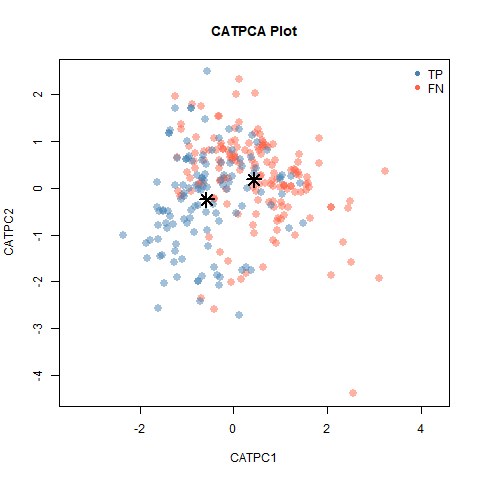

In [55]:
%%R -i df_profiles_with_constant -i num_cols -o df_loadings_catpca_1
source("plot_tools_extra.r")
out <- plot_catpca(df_profiles_with_constant, "TP", "FN", num_cols=num_cols)

df_loadings_catpca_1 <- as.data.frame(out$loadings)
colnames(df_loadings_catpca_1)[1:2] <- c("CATPC1", "CATPC2")

PC1 -> (+) vers les TP et (-) vers les FN

In [56]:
important_PC1 = df_loadings_pca_1['PC1'].sort_values(ascending=False, key=abs).head()
important_PC1_with_desc = data.replace_by_name_desc(important_PC1)
important_PC1_with_desc

MHKOOP_Home_owners                 0.585736
MZPART_Private_health_insurance    0.355099
MKOOPKLA_Purchasing_power_class    0.349983
MBERHOOG_High_status               0.298007
MOPLHOOG_High_level_education      0.252167
Name: PC1, dtype: float64

CATPC1 -> (-) vers les TP et (+) vers les FN

Clairement, CATPCA sépare les TP et FN en deux groupes. \
Si c'est une variable qui indique : "vie confortablement" alors -> TP 

In [57]:
important_CATPC1 = df_loadings_catpca_1['CATPC1'].sort_values(ascending=False, key=abs).head()
important_CATPC1_with_desc = data.replace_by_name_desc(important_CATPC1)
important_CATPC1_with_desc

MHKOOP_Home_owners                  -0.736265
MKOOPKLA_Purchasing_power_class     -0.732033
MFALLEEN_Singles                     0.668722
avg_area_income                     -0.659695
MGEMOMV_Avg_size_household_1_to_6   -0.637760
Name: CATPC1, dtype: float64

PCA et CATPCA identifient des facteurs socio-démographiques similaires, mais CATPCA est mieux adapter pour la structure ordinale et donc fait ressortir davantage certains profils (MFALLEEN). Le graphique de PCA est beaucoup plus éparpiller que celui de CATPCA. La séparation des TP et FN est beaucoup plus clair dans le graphique de CATPCA.

Je vais analyser de plus près les TP et FN.

In [58]:
X = feature_tracker.flush_to_df()
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
X_train_unscaled, *_ = feature_tracker.return_split_train_eval(to_scale=False)

model = feature_tracker.get_trained_model(print_stats=False)
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=0.1, raw=True)

df_tp = df_profiles[df_profiles["Group"] == "TP"].copy()
df_fn = df_profiles[df_profiles["Group"] == "FN"].copy()

La contribution d'un paramètre dans une regression logistique est $\beta_i x_i$. Alors pour comparer quel parametres distingue les TP vs FN. Je peux comparer les différences des contribution.

$$\Delta_i = \mathbb{E}(\beta_i x_i|TP) - \mathbb{E}(\beta_i x_i|FN)$$

Plus en plus la différence est grande, plus en plus un paramètre contribue à la décision de si c'est un TP ou FN.

In [59]:
contrib = df_profiles[X.drop('CARAVAN', axis=1).columns].mul(model.w, axis=1)
diff = contrib[df_profiles['Group'] == 'TP'].mean() - contrib[df_profiles['Group'] == 'FN'].mean()
diff.sort_values(key=abs, ascending=False).head()

PPERSAUT    0.413667
MGODGE      0.140490
MFALLEEN    0.136635
MBERARBG    0.121819
PBRAND      0.118089
dtype: float64

PPERSAUT est le paremètre principal qui décide si c'est un TP ou FN.

Je vais focus sur les FN count à PPERSAUT == 6, car la grande majorité des TP sont des PPERSAUT = 6. Je crois que sa serait plus facile de les changer à TP puisqu'ils ont la même valeur sur la variable dominante.

In [60]:
tab_tp = df_tp['PPERSAUT'].value_counts().rename('TP count')
tab_fn = df_fn['PPERSAUT'].value_counts().rename('FN count')
tab = pd.concat([tab_tp, tab_fn], axis=1).astype(int).rename_axis('PPERSAUT').reset_index()
total_row = pd.DataFrame([{
    'PPERSAUT': 'Total',
    'TP count': tab['TP count'].sum(),
    'FN count': tab['FN count'].sum()
}])

tab = pd.concat([tab, total_row], ignore_index=True)

Markdown(tab.to_markdown(index=False))

| PPERSAUT   |   TP count |   FN count |
|:-----------|-----------:|-----------:|
| 6.0        |        114 |         91 |
| 5.0        |          3 |          8 |
| 0.0        |          1 |         61 |
| Total      |        118 |        160 |

Maintenant si on focus sur les $(TP \cap PPERSAUT = 6)$ & $(FN \cap PPERSAUT = 6)$. 

Le paramètres principal est MFALLEEN (Singles). Qui est aussi, selon l'axe CATPC1, la variable qui a le plus d'influence sur si une observations se dirige vers la droite (donc vers les FN).

In [61]:
df_tp_ppersaut_6 = df_tp[df_tp['PPERSAUT'] == 6].copy()
df_fn_ppersaut_6 = df_fn[df_fn['PPERSAUT'] == 6].copy()
diff = contrib.loc[df_tp_ppersaut_6.index].mean() - contrib.loc[df_fn_ppersaut_6.index].mean()
diff.sort_values(key=abs, ascending=False).head()

MFALLEEN    0.194032
MGODGE      0.177950
MBERARBG    0.131553
MHKOOP      0.124223
PBRAND      0.112406
dtype: float64

Les deux contributions sont négatives, donc MFALLEEN pénalise les deux, mais pénalise beaucoup plus les FN que les TP.
- Les TP avec PPERSAUT = 6 ont des valeurs MFALLEEN moins défavorable.
- Mais les FN avec PPERSAUT = 6 sont davantage pénalisés par MFALLEEN. 
- Il y a deux mode pour les MFALLEEN chez les FN, 0 et 3. 
    - Ceux avec une valeur de 0 ne sont pas pénalisé par MFALLEEN, mais ceux avec une valeur de 3, oui. 
    - Eux avec une valeur de 0 sont probablement pénalisés par d'autres variables.


In [62]:
tab = pd.DataFrame({
    'Group': ['TP (PPERSAUT = 6)', 'FN (PPERSAUT = 6)'],
    'Contribution moyenne (MFALLEEN)': [
        contrib.loc[df_tp_ppersaut_6.index, 'MFALLEEN'].mean(),
        contrib.loc[df_fn_ppersaut_6.index, 'MFALLEEN'].mean()
    ],
    'Mode (MFALLEEN)': [
        df_tp_ppersaut_6['MFALLEEN'].mode().tolist(),
        df_fn_ppersaut_6['MFALLEEN'].mode().tolist()
    ]})
Markdown(tab.to_markdown(index=False))

| Group             |   Contribution moyenne (MFALLEEN) | Mode (MFALLEEN)   |
|:------------------|----------------------------------:|:------------------|
| TP (PPERSAUT = 6) |                         -0.175075 | [0.0]             |
| FN (PPERSAUT = 6) |                         -0.369107 | [0.0, 3.0]        |

D'ailleurs, l'analyse CATPCA montre que MFALLEEN est la variable la plus fortement associée à l’axe latent corrélé aux FN. 

|     (-) vers TP, (+) vers FN      |    CATPC1 |
|:----------------------------------|----------:|
| MFALLEEN_Singles                  |  0.668722 |

$$\mathrm{Logit} = \beta_0 + \beta_1 x_1 + \beta_2 x_2$$


Le modèle ne voit pas les interactions entre variables. Il additionne simplement les coefficients des variables, donc ajouter une variable qui précise une information qui n'est pas présente, du style PPERSAUT > MFALLEEN n'est pas une répétion d'informations, mais une nouvelle information tant qu'elle n'est pas parfaitement colinéaire avec une autre variable.

Presque tout les TP ont PPERSAUT = 6 et une partie importante des FN aussi. En créant une intéraction entre ces deux variables, l'effet de MFALLEEN dépend de la valeur de PPERSAUT. Donc avec cette variable, l'effet de MFALLEEN sera réduit ou annuler si PPERSAUT est élevé. 

$$\begin{aligned}
z &= w_1 ​x_1 ​+ w_2 ​x_2 ​+ w_3 ​(x_1​x_2​)+b \\
\frac{\partial z}{\partial x_1} &= w_1 + w_3x_2
\end{aligned}$$

Exemple : \
$x_2 = 6$ \
$w_1 = -0.4$ \
$w_3 = 0.1$ 

$$\frac{\partial z}{\partial x_1} = -0.4 + 0.1 \cdot  6 = 0.2$$

Mais créer l'intéraction PPERSAUTxMFALLEEN est une erreur, car PPERSAUTxMFALLEEN est hétérogène. 

PPERSAUTxMFALLEEN n'est pas ordinale car (PPERSAUT = 6)\*(MFALLEEN = 3) = (PPERSAUT = 3)\*(MFALLEEN = 6)

Mais dans mon cas, (PPERSAUT = 6)\*(MFALLEEN = 3) > (PPERSAUT = 3)\*(MFALLEEN = 6). 

Quelqu'un qui a un PPERSAUT = 6 est beaucoup plus significatif que quelqu'un qui a un MFALLEEN = 6.

In [63]:
print('Nombre de CARAVAN = 1 si :')
print('          (MFALLEEN = 6) : ', (X_train[y_train == 1]['MFALLEEN'] == 6).sum())
print('          (PPERSAUT = 6) : ', (X_train[y_train == 1]['PPERSAUT'] == 6).sum())

Nombre de CARAVAN = 1 si :
          (MFALLEEN = 6) :  4
          (PPERSAUT = 6) :  205


Le modèle va penser que (6,3) est aussi important que (3,6).

D'ailleurs, si je teste l'intéraction PPERSAUTxMFALLEEN je dois la standardiser, car sinon sa peut fausser mes résultats. Comme expliquer en haut, malgré que PPERSAUT et MFALLEEN soient ordinales. Le produit de ces deux variables ne l'est plus.

Ce qui peut arriver aussi est que le modèle va donner beaucoup trop d'attention a cette intéraction et ignorer les autres variables du a leur relativement petite variation.

In [64]:
feature_tracker.delete('PPERSAUTxMFALLEEN')
feature_tracker.add('PPERSAUTxMFALLEEN', X['PPERSAUT']*X['MFALLEEN'])
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[906 189]
 [ 30  40]]


Dans ce cas-ci, l'intéraction ne domine pas le modèle sans standardisation.

In [65]:
X_train, *_ = feature_tracker.return_split_train_eval()
coeff = pd.DataFrame({'w':model.w}, index=X.drop('CARAVAN', axis=1).columns)
max_val = X_train.max() 
(coeff['w']*max_val).sort_values(key=abs, ascending=False).head(10)

MFALLEEN            -1.717045
MGODGE              -1.671499
PPERSAUT             1.300767
MGODPR              -1.168208
MBERBOER            -1.052674
MSKD                -1.039890
MBERARBG            -0.953232
MRELSA              -0.843449
PPERSAUTxMFALLEEN    0.810052
MGEMLEEF            -0.781308
dtype: float64

Je crois quand même que standardiser PPERSAUTxMFALLEEN est mieux içi. La variable non-standardiser fonctionne bien seulement parce qu'il y a peu d'observation avec un MFALLEEN > PPERSAUT sur le set de validation. Donc peut-etre que sa fonctionne bien içi oui, mais peut-etre aussi que le set d'évaluation finale ne contient pas du tout la même structure de données. 

Si on regarde la matrice de confusion du training set sans standardisation, on peut voir qu'elle perd 2 TP, mais gagne 18 FN, malgré le gain de +3 TP sur le set de validation avec seulement +7 FN additionnel. Les valeur des données du set de validation favorise cette variable


La matrice de confusion avant l'ajout d'une des variables sur le training set est : $$\begin{bmatrix} 3670 & 708 \\ 160 & 118 \end{bmatrix}$$


| PPERSAUTxMFALLEEN        | Matrice de confusion (val set)                        | Matrice de confusion (train set)                         |
| ------------------------ | ----------------------------------------------------- | -------------------------------------------------------- |
| **Avec standardisation** | $$\begin{bmatrix} 909 & 186 \\ 33 & 37 \end{bmatrix}$$ | $$\begin{bmatrix} 3662 & 716 \\ 160 & 118 \end{bmatrix}$$|
| **Sans standardisation** | $$\begin{bmatrix} 906 & 189 \\ 30 & 40 \end{bmatrix}$$ | $$\begin{bmatrix} 3652 & 726 \\ 162 & 116 \end{bmatrix}$$|



La variable is_PPERSAUT_6xMFALLEEN est la plus efficace. En plus, elle donne des résultats identique a PPERSAUTxMFALLEEN non-standardiser. Elle vise les clients avec un PPERSAUT = 6, qui représente la quasi-totalité des TP et plus que le moitié des FN.

In [66]:
feature_tracker.delete('PPERSAUTxMFALLEEN')
X = feature_tracker.flush_to_df()

feature_tracker.add('PPERSAUTxMFALLEEN', X['PPERSAUT']*X['MFALLEEN'], toScale=True)
feature_tracker.add('PPERSAUT_DOM_MFALLEEN', (X['PPERSAUT'] > X['MFALLEEN']).astype(int))
feature_tracker.add('is_PPERSAUT_6xMFALLEEN', ((X['PPERSAUT'] == 6) * (X['MFALLEEN'])).astype(int))
feature_tracker.add('is_PPERSAUT_6xMFALLEEN_geq_3', (((X['PPERSAUT'] == 6) & (X['MFALLEEN'] >= 3)) * X['MFALLEEN']).astype(int))
vars_to_test = ['PPERSAUTxMFALLEEN', 'PPERSAUT_DOM_MFALLEEN', 'is_PPERSAUT_6xMFALLEEN', 'is_PPERSAUT_6xMFALLEEN_geq_3']

feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, threshold=0.1, print_metrics=False)

|----- Variable de base -----|
Threshold   : 0.1000
[[913 182]
 [ 33  37]]

|----- PPERSAUTxMFALLEEN -----|
Threshold   : 0.1000
[[909 186]
 [ 33  37]]

|----- PPERSAUT_DOM_MFALLEEN -----|
Threshold   : 0.1000
[[915 180]
 [ 33  37]]

|----- is_PPERSAUT_6xMFALLEEN -----|
Threshold   : 0.1000
[[906 189]
 [ 30  40]]

|----- is_PPERSAUT_6xMFALLEEN_geq_3 -----|
Threshold   : 0.1000
[[909 186]
 [ 31  39]]



En plus, elle ne souffre pas du même défaut que PPERSAUTxMFALLEEN non-standardiser. 

La variable non-standardiser -> -2 TP, +18 FN \
is_PPERSAUT_6xMFALLEEN -> +2 TP, +21 FN

In [67]:
feature_tracker.delete('PPERSAUTxMFALLEEN')
feature_tracker.add('PPERSAUTxMFALLEEN', X['PPERSAUT']*X['MFALLEEN'], toScale=False)
vars_to_test = ['PPERSAUTxMFALLEEN', 'is_PPERSAUT_6xMFALLEEN', 'is_PPERSAUT_6xMFALLEEN_geq_3']
X = feature_tracker.flush_to_df()

feature_tracker.restore_list(vars_to_test)

feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, threshold=0.1, print_metrics=False, test_on_train=True)

|----- Variable de base -----|
Threshold   : 0.1000
[[3670  708]
 [ 160  118]]

|----- PPERSAUTxMFALLEEN -----|
Threshold   : 0.1000
[[3652  726]
 [ 162  116]]

|----- is_PPERSAUT_6xMFALLEEN -----|
Threshold   : 0.1000
[[3649  729]
 [ 158  120]]

|----- is_PPERSAUT_6xMFALLEEN_geq_3 -----|
Threshold   : 0.1000
[[3651  727]
 [ 163  115]]



In [68]:
feature_tracker.restore('is_PPERSAUT_6xMFALLEEN')
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[906 189]
 [ 30  40]]


MGODGE est le prochain paramètre principale.

In [69]:
X_train, y_train, *_ = feature_tracker.return_split_train_eval()
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=0.1, raw=True)
contrib = FeatureTools.get_df_conf_matrix_contrib(feature_tracker, model)
diff = contrib[df_profiles['Group'] == 'TP'].mean() - contrib[df_profiles['Group'] == 'FN'].mean()
diff.sort_values(key=abs, ascending=False).head()

PPERSAUT    0.378984
MGODGE      0.139305
MBERARBG    0.124399
PBRAND      0.123497
MFALLEEN    0.104887
dtype: float64

In [70]:
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

df_tp_ppersaut_6 = df_tp[df_tp['PPERSAUT'] == 6].copy()
df_fn_ppersaut_6 = df_fn[df_fn['PPERSAUT'] == 6].copy()

diff = contrib.loc[df_tp_ppersaut_6.index].mean() - contrib.loc[df_fn_ppersaut_6.index].mean()
diff.sort_values(key=abs, ascending=False).head()

MGODGE      0.174892
MFALLEEN    0.146075
MBERARBG    0.139681
MHKOOP      0.128525
PBRAND      0.123965
dtype: float64

Pareil, içi que MFALLEEN. Les deux contributions sont négatives, donc MGODGE pénalise les deux, mais pénalise beaucoup plus les FN que les TP.

In [71]:
tab = FeatureTools.get_df_conf_matrix_contrib_analysis('PPERSAUT', 6, 'MGODGE', feature_tracker, model)
Markdown(tab.to_markdown(index=False)) 

| Group             |   Contribution moyenne (MGODGE) | Mode (MGODGE)   |
|:------------------|--------------------------------:|:----------------|
| TP (PPERSAUT = 6) |                       -0.486    | [3.0]           |
| FN (PPERSAUT = 6) |                       -0.660893 | [5.0]           |

In [72]:
pd.crosstab(df_fn['PPERSAUT'], df_fn['MGODGE'])

MGODGE,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
PPERSAUT,,,,,,,,
0.0,5,4,11,22,12,4,0,3
5.0,0,0,1,3,4,1,0,0
6.0,5,4,13,16,20,25,4,1


In [73]:
X = feature_tracker.flush_to_df()
feature_tracker.add('PPERSAUT_DOM_MGODGE', (X['PPERSAUT'] > X['MGODGE']).astype(int))
feature_tracker.add('is_high_no_religion_area', (X['MGODGE'] >= 4).astype(int))
feature_tracker.add('is_low_no_religion_area', (X['MGODGE'] <= 3).astype(int))

X = feature_tracker.flush_to_df()

feature_tracker.add('PPERSAUTxis_high_no_religion_area', X['PPERSAUT']*X['is_high_no_religion_area'])
feature_tracker.add('PPERSAUTxis_low_no_religion_area', X['PPERSAUT']*X['is_low_no_religion_area'])
vars_to_test = ['PPERSAUT_DOM_MGODGE', 'is_high_no_religion_area', 'is_low_no_religion_area', 'PPERSAUTxis_high_no_religion_area', 'PPERSAUTxis_low_no_religion_area']
feature_tracker.remove_list(vars_to_test)
X = feature_tracker.flush_to_df()

feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, threshold=0.1, print_metrics=False)

|----- Variable de base -----|
Threshold   : 0.1000
[[906 189]
 [ 30  40]]

|----- PPERSAUT_DOM_MGODGE -----|
Threshold   : 0.1000
[[905 190]
 [ 30  40]]

|----- is_high_no_religion_area -----|
Threshold   : 0.1000
[[907 188]
 [ 30  40]]

|----- is_low_no_religion_area -----|
Threshold   : 0.1000
[[908 187]
 [ 30  40]]

|----- PPERSAUTxis_high_no_religion_area -----|
Threshold   : 0.1000
[[907 188]
 [ 30  40]]

|----- PPERSAUTxis_low_no_religion_area -----|
Threshold   : 0.1000
[[910 185]
 [ 30  40]]



In [74]:
feature_tracker.restore('PPERSAUTxis_low_no_religion_area')
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[910 185]
 [ 30  40]]


Je vais me faire un profil sur les présents TP.

In [75]:
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

df_tp_ppersaut_6 = df_tp[df_tp['PPERSAUT'] == 6].copy()
df_fn_ppersaut_6 = df_fn[df_fn['PPERSAUT'] == 6].copy()

contrib_tp = contrib.loc[df_tp_ppersaut_6.index].mean()
contrib_tp.sort_values(key=abs, ascending=False).head(10)

PPERSAUT    0.985759
MGODPR     -0.649561
MGODGE     -0.488160
MAUT1      -0.446813
MGEMLEEF   -0.380198
MRELGE     -0.342093
MHKOOP      0.288796
PBRAND      0.288420
MFALLEEN   -0.230734
MFWEKIND   -0.225460
dtype: float64

Ce qui distingue majoritairement les TP vs FN est 
- PPERSAUT (Contribution car policies)
    - TP : Presque uniquement 6
    - FN : Majoritairement 6 mais aussi 0 (encore)
- MAUT1 (1 car)
    - TP : surtout 7 
    - FN : étalé entre 7 et 6
- PBRAND (Contribution fire policie)
    - TP : Surtout 4
    - FN : Surtout 0, mais aussi 4

In [76]:
vars = contrib_tp.sort_values(key=abs, ascending=False).head(10).index
df_dom = FeatureTools.get_df_dom(vars, feature_tracker, thresh=0.2)
Markdown(df_dom.to_markdown(index=False))

| Variable   | TP valeurs dominantes   | TP (count)                       | FN valeurs dominantes   | FN (count)                       |
|:-----------|:------------------------|:---------------------------------|:------------------------|:---------------------------------|
| PPERSAUT   | 6                       | 118 / 121                        | 0<br>6                  | 61 / 157<br>87 / 157             |
| MGODPR     | 4<br>5                  | 27 / 121<br>37 / 121             | 4<br>5                  | 43 / 157<br>42 / 157             |
| MGODGE     | 2<br>3                  | 27 / 121<br>32 / 121             | 3<br>4                  | 40 / 157<br>37 / 157             |
| MAUT1      | 6<br>7                  | 26 / 121<br>44 / 121             | 6<br>7                  | 47 / 157<br>50 / 157             |
| MGEMLEEF   | 2<br>3                  | 32 / 121<br>63 / 121             | 2<br>3                  | 38 / 157<br>82 / 157             |
| MRELGE     | 7<br>9                  | 41 / 121<br>31 / 121             | 6<br>7                  | 34 / 157<br>52 / 157             |
| MHKOOP     | 9                       | 48 / 121                         | -                       | -                                |
| PBRAND     | 4                       | 77 / 121                         | 0<br>3<br>4             | 72 / 157<br>38 / 157<br>38 / 157 |
| MFALLEEN   | 0<br>1<br>2             | 48 / 121<br>25 / 121<br>32 / 121 | 0                       | 49 / 157                         |
| MFWEKIND   | 4                       | 27 / 121                         | -                       | -                                |

Puisque je sais que PBRAND et PPERSAUT sont des variables significatives, je crois que créer une interaction entre ces termes pourrait être bénéfique. 

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 28 | PPERSAUT  |      0.1626 | 1.1766 |      1.1016 |      1.2567 |
| 40 | PBRAND    |      0.0905 | 1.0947 |      1.0057 |      1.1916 |

Dans les FN, si on regarde $(FN \cap PBRAND > 0)$, on peut voir qu'il y a 55 potentiels TP dans le training set qui ont PPERSAUT > 0. L'intéraction a l'air d'avoir du potentiel. 

In [77]:
df_sub = df_fn[(df_fn["PBRAND"] > 0) & (df_fn["PPERSAUT"] > 0)]
pd.crosstab(df_sub["PPERSAUT"], df_sub["PBRAND"], margins=True)

PBRAND,1.0,2.0,3.0,4.0,5.0,6.0,All
PPERSAUT,,,,,,,
5.0,1,0,3,4,0,0,8
6.0,1,4,23,17,1,1,47
All,2,4,26,21,1,1,55


Puisque la majorité des FN avec un PBRAND > 0 se situe sur 3 et 4. Je vais viser ce groupe.

In [78]:
pd.crosstab(df_tp['PPERSAUT'], df_tp['PBRAND'], margins=True)

PBRAND,0.0,1.0,2.0,3.0,4.0,5.0,All
PPERSAUT,,,,,,,
0.0,0,0,0,0,1,0,1
5.0,0,0,0,0,2,0,2
6.0,19,1,1,17,74,6,118
All,19,1,1,17,77,6,121


J'ai tester deux variables : PPERSAUTxPBRAND_geq_3 et PPERSAUTx_is_PBRAND_3_4.
- PPERSAUTxPBRAND_geq_3 -> +3 TP, +5 FN
- PPERSAUTx_is_PBRAND_3_4 -> +1 TP, +3 FN

In [79]:
X = feature_tracker.flush_to_df()
feature_tracker.remove('PPERSAUTxPBRAND_geq_3')
feature_tracker.remove('PPERSAUTx_is_PBRAND_3_4')
X = feature_tracker.flush_to_df()
feature_tracker.add('PPERSAUTxPBRAND_geq_3',((X["PPERSAUT"])*(X['PBRAND'] >= 3)))
feature_tracker.add('PPERSAUTx_is_PBRAND_3_4',((X["PPERSAUT"])*(X['PBRAND'].isin([3,4]))))
feature_tracker.add('PPERSAUTx_is_PBRAND_4',((X["PPERSAUT"])*(X['PBRAND'].isin([4]))))

vars_to_test = ['PPERSAUTxPBRAND_geq_3', 'PPERSAUTx_is_PBRAND_3_4', 'PPERSAUTx_is_PBRAND_4']
feature_tracker.remove_list(vars_to_test)

X = feature_tracker.flush_to_df()
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, print_metrics=False, threshold=0.1)

|----- Variable de base -----|
Threshold   : 0.1000
[[910 185]
 [ 30  40]]

|----- PPERSAUTxPBRAND_geq_3 -----|
Threshold   : 0.1000
[[905 190]
 [ 27  43]]

|----- PPERSAUTx_is_PBRAND_3_4 -----|
Threshold   : 0.1000
[[907 188]
 [ 29  41]]

|----- PPERSAUTx_is_PBRAND_4 -----|
Threshold   : 0.1000
[[943 152]
 [ 35  35]]



In [80]:
print('|----- Avant les variables (training set) -----|')
feature_tracker.remove('PPERSAUTxPBRAND_geq_3')
feature_tracker.remove('PPERSAUTx_is_PBRAND_3_4')
tab = FeatureTools.get_df_conf_matrix_count_by_var('PPERSAUT', feature_tracker)
display(Markdown(tab.to_markdown(index=False)))

|----- Avant les variables (training set) -----|


| PPERSAUT   |   FN count |   TP count |
|:-----------|-----------:|-----------:|
| 0.0        |         61 |          1 |
| 5.0        |          9 |          2 |
| 6.0        |         87 |        118 |
| Total      |        157 |        121 |

Dans le set de training
- PPERSAUTxPBRAND_geq_3 -> +17, -3 FN
- PPERSAUTx_is_PBRAND_3_4 -> +16 TP, -18 FN
    - un des TP est PPERSAUT = 5

In [81]:
vars_to_test = ['PPERSAUTxPBRAND_geq_3', 'PPERSAUTx_is_PBRAND_3_4']
X = feature_tracker.flush_to_df()
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, test_on_train=True, threshold=0.1, print_metrics=False)


|----- Variable de base -----|
Threshold   : 0.1000
[[3661  717]
 [ 157  121]]

|----- PPERSAUTxPBRAND_geq_3 -----|
Threshold   : 0.1000
[[3664  714]
 [ 140  138]]

|----- PPERSAUTx_is_PBRAND_3_4 -----|
Threshold   : 0.1000
[[3679  699]
 [ 141  137]]



Je vais garder PPERSAUTx_is_PBRAND_3_4, car elle est plus stable que PPERSAUTxPBRAND_geq_3. aaaaaaaaaaaa

In [82]:
feature_tracker.restore('PPERSAUTx_is_PBRAND_3_4')
feature_tracker.remove('PPERSAUTxPBRAND_geq_3')
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[907 188]
 [ 29  41]]


In [83]:
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

Maintenant, je vais regarder la PCA une derniere fois.

Maintenant, on peut clairement voir pourquoi utiliser PCA sur des variables ordinales n'est pas un bon choix. PCA sépare principalement les TP et FN selon l'axe PC2, car l'ajout des termes d'intéractions PPERSAUTxPBRAND_geq_3 et PPERSAUTxMFALLEEN cible un type de profil en particulier (PPERSAUT élevé). Donc, la PCA calcule une grande variance associer à ce pattern entre ce profil viser vs les autres profils non-affectés. 

La séparation est un artefact de la maximisation de la variance par la PCA et non une indication d'un pattern cacher dans les données. Elle fait sa parce qu'elle traite toute les variables comme continues


En d'autres mots, elle fait juste repéter une information déjà présente dans les variables.

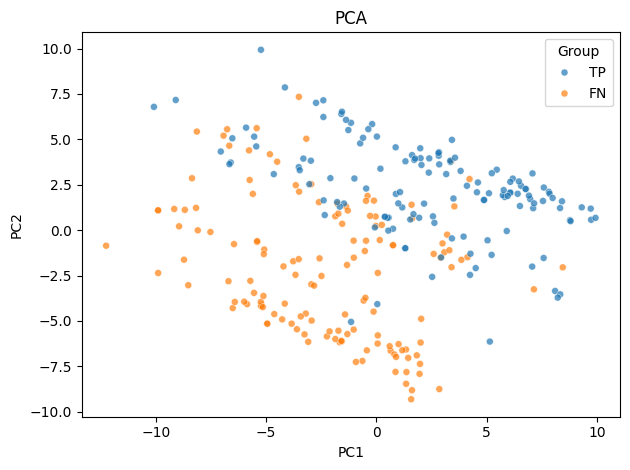

In [84]:
X = feature_tracker.flush_to_df(removeTargets=True)
model = feature_tracker.get_trained_model(print_stats=False)
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()

df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=model.threshold, raw=True)
num_cols, cat_cols = feature_tracker.get_num_cat_cols()
df_loadings_pca_2 = plot_tools.plot_PCA(cat_cols, num_cols, df_profiles, TP_FN=True)

In [85]:
df_loadings_pca_2.abs().sort_values(by="PC2", ascending=False).head()

,PC1,PC2
PPERSAUTx_is_PBRAND_3_4,0.223847,0.558813
PPERSAUT,0.148806,0.485158
PPERSAUTxis_low_no_religion_area,0.358117,0.382945
MHKOOP,0.514667,0.259921
is_PPERSAUT_6xMFALLEEN,0.101967,0.234368


In [86]:
df_profiles_with_constant = data.prepare_catpca_df(df_profiles, cols, cat_cols)
cols = df_profiles_with_constant.columns
col_group_idx = cols.get_loc('Group')
cols = cols.delete(col_group_idx)

Maintenant, si on regarde CATPCA, elle fournit une représentation plus fidèle de la structure des données puisqu'elle respecte explicitement la nature des données. Elle n'amplifie pas les écart numériques causer par les termes d'intéractions et une valeur de PPERSAUT élevés. 

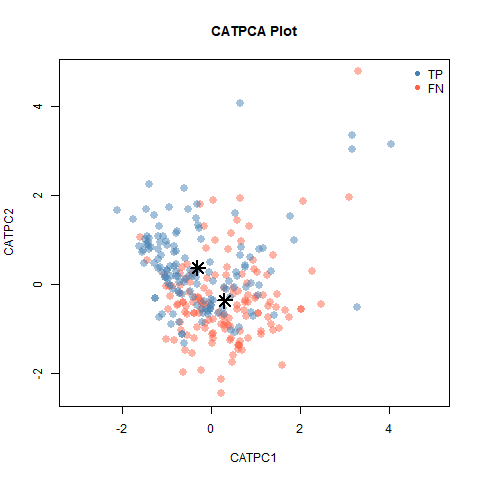

In [87]:
%%R -i df_profiles_with_constant -i num_cols -o df_loadings_catpca_2
source("plot_tools_extra.r")
out <- plot_catpca(df_profiles_with_constant, "TP", "FN", num_cols=num_cols)

df_loadings_catpca_2 <- as.data.frame(out$loadings)
colnames(df_loadings_catpca_2)[1:2] <- c("CATPC1", "CATPC2")

Cette fois ci, je vais utiliser la LDA. Elle permet de séparer les différentes classes en sous-groupe en trouvant des axes qui maximisent la séparation entre groupes.

$X = (x_1,x_2, \ldots x_n) = $ les variables (ou features) \
$Y \in \{0, 1\}$, où 0 et 1 sont les classes (TP et FN par exemple)

Un axe LDA est défini par $$LDA = w^\top X = w_1x_1 + w_2x_2 + \ldots + w_nx_n$$

$$S = \frac{\sigma^2_{\text{inter}}}{\sigma^2_{\text{intra}}} = \frac{(w^\top (\mu_1 - \mu_0))^2}{w^\top (\Sigma_0 + \Sigma_1) w} = w \propto (\Sigma_0 + \Sigma_1)^{-1}(\mu_1 - \mu_0)$$

Les somme $\Sigma_0$ et $\Sigma_1$ sont les matrices de covariance de la classe 0 et 1

$$\Sigma_k = \mathrm{Cov}(X| Y = k) = \frac{1}{n_k-1}(X_k-\mu_k)^\top(X_k-\mu_k) =
\begin{bmatrix}
\mathrm{Var}(x_1) & \mathrm{Cov}(x_1,x_2) & \cdots \\
\mathrm{Cov}(x_2,x_1) & \mathrm{Var}(x_2) & \cdots \\
\vdots & & \ddots
\end{bmatrix}$$

où : $$\mathrm{Cov}(x_i,x_j) = \mathbb{E}\big[(x_i​−\mu_{k,i}​)(x_j​−\mu_{k,j}) | Y = k\big]$$

Exemple : \
$x_1 = PPERSAUT$ \
$x_2 = PBRAND$

$Y = 0:FN$ \
$Y = 1:TP$ 

$X_0 =
\begin{bmatrix}
2 & 1 \\
3 & 2 \\
4 & 2
\end{bmatrix}, \quad \mu_0 = \begin{bmatrix}
3, \frac{5}{3}
\end{bmatrix}$

$X_1 =
\begin{bmatrix}
5 & 5 \\
6 & 5 \\
7 & 6
\end{bmatrix}, \quad \mu_1 = \begin{bmatrix}
6, \frac{17}{3}
\end{bmatrix}$

$n_0 = n_1 = 3$

$$\mu_1 - \mu_0 = \begin{bmatrix}
6 - 3, \frac{17}{3} - \frac{5}{3}
\end{bmatrix} = \begin{bmatrix}
3, 4
\end{bmatrix}$$

$$X_0 - J_{3,1}\mu_0 = 
\begin{bmatrix}
2-3 & 1-\tfrac{5}{3} \\
3-3 & 2-\tfrac{5}{3} \\
4-3 & 2-\tfrac{5}{3}
\end{bmatrix} = \begin{bmatrix}
-1 & -\tfrac{2}{3} \\
0 & \tfrac{1}{3} \\
1 & \tfrac{1}{3}
\end{bmatrix}
$$

$$
X_1 - J_{3,1}\mu_1 = \begin{bmatrix}
5-6 & 5-\tfrac{17}{3} \\
6-6 & 5-\tfrac{17}{3} \\
7-6 & 6-\tfrac{17}{3}
\end{bmatrix} = \begin{bmatrix}
-1 & -\tfrac{2}{3} \\
0 & -\tfrac{2}{3} \\
1 & \tfrac{1}{3} \\
\end{bmatrix} 
$$

$$
\Sigma_0 = \frac{1}{n_0}(X_0 - \mu_0)^\top(X_0 - \mu_0) = \frac{1}{3}\begin{bmatrix}
2 & 1 \\
1 & \tfrac{2}{3}
\end{bmatrix} = \begin{bmatrix}
\tfrac{2}{3} & \tfrac{1}{3} \\
\tfrac{1}{3} & \tfrac{2}{9}
\end{bmatrix} 
$$

$$
\Sigma_1 = \frac{1}{n_1}(X_1 - \mu_1)^\top(X_1 - \mu_1) = 
\frac{1}{3}\begin{bmatrix}
2 & 1 \\
1 & 1
\end{bmatrix} = \begin{bmatrix}
\tfrac{2}{3} & \tfrac{1}{3} \\
\tfrac{1}{3} & \tfrac{1}{3} \\
\end{bmatrix}
$$

$$\Sigma_0 + \Sigma_1 = \begin{bmatrix}
\tfrac{4}{3} & \tfrac{2}{3} \\
\tfrac{2}{3} & \tfrac{5}{9} \\
\end{bmatrix}$$

$$(\Sigma_0 + \Sigma_1)^{-1} = 
\begin{bmatrix}
\tfrac{18}{8} & \tfrac{-9}{4} \\
\tfrac{-9}{4} & \tfrac{9}{2} \\
\end{bmatrix}$$

$$w \propto (\Sigma_0 + \Sigma_1)^{-1}(\mu_1 - \mu_0) = \begin{bmatrix}
\tfrac{18}{8} & \tfrac{-9}{4} \\
\tfrac{-9}{4} & \tfrac{9}{2} 
\end{bmatrix} \begin{bmatrix}
3 \\
4
\end{bmatrix} = \begin{bmatrix}
\tfrac{-27}{8} \\
\tfrac{45}{4}
\end{bmatrix}$$

Et puisque $w$ est un eigenvector 

$$w \propto \begin{bmatrix}
-1 \\
4
\end{bmatrix}$$ 

Donc 
$$ LDA = (-1) \cdot PPERSAUT + 4 \cdot PBRAND $$

Ce qui veut dire que la variable PBRAND augmente fortement le score LDA et pousse vers la classe 1 (TP dans notre cas) plus en plus qu'elle est élevé. Tandis qu'une valeur élevée de PPERSAUT diminue le score LDA et pousse vers la classe 0 (FN dans notre cas)


Mais, le même probleme que PCA ce présente içi. La LDA assume également que les relations des variables sont linéaires. $$LDA = w^\top X$$ Alors, elle aussi utilise des distances euclidiennes, ce qui implique que les distances entre les valeurs des variables sont les mêmes. Mais encore une fois, rien ne garantit que l'importance des valeurs de certaine variables augmente/diminue de façon linéaire, comme prouver précédemment avec PPERSAUT.


Si on observe les données de la LDA, on voit qu'elle tombe dans le meme piege que PCA. Elle repete simplement l'information contenu dans les variables.

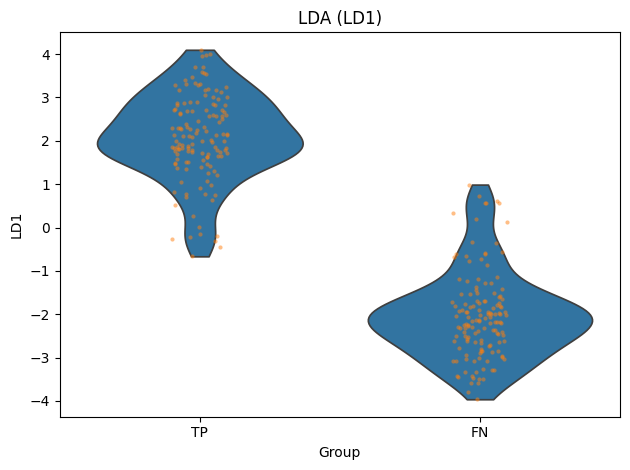

In [88]:
X = feature_tracker.flush_to_df(removeTargets=True)
model = feature_tracker.get_trained_model(print_stats=False)
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=model.threshold, raw=True)

num_cols, cat_cols = feature_tracker.get_num_cat_cols()

loadings = plot_tools.plot_LDA(cat_cols, num_cols, df_profiles, TP_FN=True)

In [89]:
loadings.head()

,LD1
PPERSAUTx_is_PBRAND_3_4,8.401278
MGODPR,-1.781936
MGODGE,-1.707705
MFWEKIND,-1.597683
PBRAND,-1.355184


In [90]:
model = feature_tracker.get_trained_model()
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

Threshold   : 0.1000
[[907 188]
 [ 29  41]]


In [91]:
important_CATPC1_with_desc

MHKOOP_Home_owners                  -0.736265
MKOOPKLA_Purchasing_power_class     -0.732033
MFALLEEN_Singles                     0.668722
avg_area_income                     -0.659695
MGEMOMV_Avg_size_household_1_to_6   -0.637760
Name: CATPC1, dtype: float64

In [92]:
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

In [93]:
pd.crosstab(df_tp['PPERSAUT'], df_tp['MHKOOP'], margins=True)

MHKOOP,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
PPERSAUT,,,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,1,0,1
5.0,0,0,0,2,1,0,0,2,0,0,5
6.0,7,5,10,6,10,10,9,13,13,48,131
All,7,5,10,8,11,10,9,15,14,48,137


In [94]:
pd.crosstab(df_fn['PPERSAUT'], df_fn['MHKOOP'], margins=True)

MHKOOP,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
PPERSAUT,,,,,,,,,,,
0.0,6,1,3,4,5,2,8,10,7,15,61
5.0,0,1,0,0,0,1,1,0,3,0,6
6.0,11,8,5,4,7,4,11,7,7,10,74
All,17,10,8,8,12,7,20,17,17,25,141


In [95]:
X = feature_tracker.flush_to_df()
feature_tracker.add('PPERSAUTxMHKOOP_geq_4',((X["PPERSAUT"])*(X['MHKOOP'] >= 4)))
feature_tracker.add('PPERSAUTxMHKOOP_geq_6',((X["PPERSAUT"])*(X['MHKOOP'] >= 6)))
feature_tracker.add('PPERSAUT_6xMKOOPKLA', ((X["PPERSAUT"] == 6)*(X['MHKOOP'])))

vars_to_test = ['PPERSAUTxMHKOOP_geq_4', 'PPERSAUTxMHKOOP_geq_6', 'PPERSAUT_6xMKOOPKLA']
feature_tracker.remove_list(vars_to_test)

X = feature_tracker.flush_to_df()
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, print_metrics=False, threshold=0.1)

|----- Variable de base -----|
Threshold   : 0.1000
[[907 188]
 [ 29  41]]

|----- PPERSAUTxMHKOOP_geq_4 -----|
Threshold   : 0.1000
[[910 185]
 [ 28  42]]

|----- PPERSAUTxMHKOOP_geq_6 -----|
Threshold   : 0.1000
[[914 181]
 [ 27  43]]

|----- PPERSAUT_6xMKOOPKLA -----|
Threshold   : 0.1000
[[915 180]
 [ 30  40]]



sur train set, ajoute pas, mais reduit FP.

In [96]:
vars_to_test = ['PPERSAUTxMHKOOP_geq_6']
feature_tracker.remove_list(vars_to_test)

X = feature_tracker.flush_to_df()
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, print_metrics=False, threshold=0.1, test_on_train=True)

|----- Variable de base -----|
Threshold   : 0.1000
[[3679  699]
 [ 141  137]]

|----- PPERSAUTxMHKOOP_geq_6 -----|
Threshold   : 0.1000
[[3689  689]
 [ 141  137]]



In [97]:
feature_tracker.restore('PPERSAUTxMHKOOP_geq_6')
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[914 181]
 [ 27  43]]


In [98]:
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

In [99]:
pd.crosstab(df_tp['PPERSAUT'], df_tp['MKOOPKLA'], margins=True)

MKOOPKLA,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,All
PPERSAUT,,,,,,,,,
0.0,0,0,0,0,0,1,0,0,1
5.0,0,0,0,0,3,1,1,0,5
6.0,3,5,24,12,7,26,31,23,131
All,3,5,24,12,10,28,32,23,137


In [100]:
pd.crosstab(df_fn['PPERSAUT'], df_fn['MKOOPKLA'], margins=True)

MKOOPKLA,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,All
PPERSAUT,,,,,,,,,
0.0,7,0,11,10,7,9,14,3,61
5.0,1,0,2,3,0,0,0,0,6
6.0,6,6,24,13,7,10,4,4,74
All,14,6,37,26,14,19,18,7,141


In [101]:
X = feature_tracker.flush_to_df()
feature_tracker.add('PPERSAUTxMKOOPKLA_geq_3',((X["PPERSAUT"])*(X['MKOOPKLA'] >= 3)))
feature_tracker.add('PPERSAUT_6xMKOOPKLA', ((X["PPERSAUT"] == 6)*(X['MKOOPKLA'])))

vars_to_test = ['PPERSAUTxMKOOPKLA_geq_3', 'PPERSAUT_6xMKOOPKLA']
feature_tracker.remove_list(vars_to_test)

X = feature_tracker.flush_to_df()
feature_tracker.feature_comparator(X, cols_to_test=vars_to_test, print_metrics=False, threshold=0.1)

|----- Variable de base -----|
Threshold   : 0.1000
[[914 181]
 [ 27  43]]

|----- PPERSAUTxMKOOPKLA_geq_3 -----|
Threshold   : 0.1000
[[914 181]
 [ 28  42]]

|----- PPERSAUT_6xMKOOPKLA -----|
Threshold   : 0.1000
[[921 174]
 [ 26  44]]



In [102]:
feature_tracker.restore('PPERSAUT_6xMKOOPKLA')
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[921 174]
 [ 26  44]]


In [103]:
corr = FeatureTools.find_correlated_cols(X_train, toPlot=False)
corr

[]

In [104]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=model.threshold, raw=True)
cols = X_train.columns
num_cols, cat_cols = feature_tracker.get_num_cat_cols()

df_profiles_with_constant = data.prepare_catpca_df(df_profiles, cols, cat_cols)
cols = df_profiles_with_constant.columns
col_group_idx = cols.get_loc('Group')
cols = cols.delete(col_group_idx)

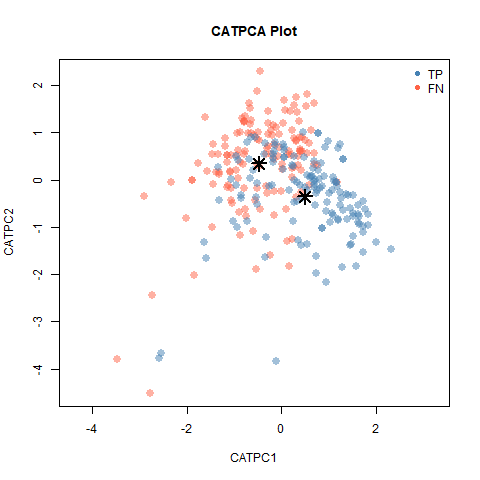

In [105]:
%%R -i df_profiles_with_constant -i num_cols -o df_loadings_catpca_2 -o df_scores_catpca_2
source("plot_tools_extra.r")
out <- plot_catpca(df_profiles_with_constant, "TP", "FN", num_cols=num_cols)

df_loadings_catpca_2 <- as.data.frame(out$loadings)
colnames(df_loadings_catpca_2)[1:2] <- c("CATPC1", "CATPC2")

df_scores_catpca_2 <- as.data.frame(out$scores) 
colnames(df_scores_catpca_2)[1:2] <- c("CATPC1", "CATPC2")

In [106]:
important_CATPC2 = df_loadings_catpca_2['CATPC2'].sort_values(ascending=False, key=abs).head()
important_CATPC2_with_desc = data.replace_by_name_desc(important_CATPC2)
important_CATPC2_with_desc

MFWEKIND_Household_with_children     0.623818
is_PPERSAUT_6xMFALLEEN              -0.619163
MGEMOMV_Avg_size_household_1_to_6    0.577175
MFALLEEN_Singles                    -0.540244
MGEMLEEF_Avg_age_see_L1             -0.534738
Name: CATPC2, dtype: float64

Peu importe la variable que j'ajoute, le modèle semble avoir plafonner. Les TP tourne toujours autour de 40-45 tout en gardant les FP stable.

In [107]:
base_model = feature_tracker.get_trained_model(name="Base Model")

Threshold   : 0.1000
[[921 174]
 [ 26  44]]


Je vais m'areter ici pour l'ajout de features. J'ai pu ajouté plusieurs TP et c'est un de mes meilleurs essai.

In [108]:
features_cols = feature_tracker.get_features_cols()
features_cols

['PPERSAUTxis_low_no_religion_area',
 'is_PPERSAUT_6xMFALLEEN',
 'PPERSAUTx_is_PBRAND_3_4',
 'avg_area_income',
 'PPERSAUTxMHKOOP_geq_6',
 'PPERSAUT_6xMKOOPKLA']

In [109]:
base_model.top_k_caravan_policy_owners()

Top 233 contient:         46 positifs


In [110]:
income_cols = ['MINKM3045', 'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM'] #MINKM30 pas la car référence

feature_tracker.remove("avg_area_income")
feature_tracker.restore_list(income_cols)

X = feature_tracker.flush_to_df()

model = feature_tracker.get_trained_model(print_top_k=True)

Threshold   : 0.1000
[[925 170]
 [ 26  44]]
Top 233 contient:         46 positifs


In [111]:
print("|----- avg_area_income (train set) -----|")
base_model.top_k_caravan_policy_owners(on_train_set=True)

print("\n|----- MINK* (train set) -----|")
model.top_k_caravan_policy_owners(on_train_set=True)

|----- avg_area_income (train set) -----|
Top 931 contient:         147 positifs

|----- MINK* (train set) -----|
Top 931 contient:         150 positifs


In [112]:
base_model = feature_tracker.get_trained_model(print_top_k=True)

Threshold   : 0.1000
[[925 170]
 [ 26  44]]
Top 233 contient:         46 positifs


In [113]:
all_total_vars = ["total_life_health_policies", "total_third_party_policies", "total_daily_vehicle_policies", 
              "total_work_heavy_vehicle_policies", "total_property_policies", "total_leisure_vehicle_policies"]

feature_tracker.restore_list(all_total_vars)
X = feature_tracker.flush_to_df()

model_all_total = feature_tracker.get_trained_model(print_top_k=True)


Threshold   : 0.1000
[[920 175]
 [ 24  46]]
Top 233 contient:         47 positifs


In [114]:
model_all_total.top_k_caravan_policy_owners(on_train_set=True)

Top 931 contient:         154 positifs


In [115]:
base_model = feature_tracker.get_trained_model(print_top_k=True)
print("\ntrain set")
base_model.top_k_caravan_policy_owners(on_train_set=True)

Threshold   : 0.1000
[[920 175]
 [ 24  46]]
Top 233 contient:         47 positifs

train set
Top 931 contient:         154 positifs


In [116]:
feature_tracker.remove('PPERSAUTx_is_PBRAND_3_4')
feature_tracker.remove('PPERSAUTxPBRAND_geq_3')
X = feature_tracker.flush_to_df()

print("|----- PPERSAUTx_is_PBRAND_3_4  -----|")
feature_tracker.remove('PPERSAUTxPBRAND_geq_3')
feature_tracker.restore("PPERSAUTx_is_PBRAND_3_4")
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model(print_top_k=True)
model.top_k_caravan_policy_owners(on_train_set=True)

print("\n|----- PPERSAUTxPBRAND_geq_3  -----|")
feature_tracker.remove('PPERSAUTx_is_PBRAND_3_4')
feature_tracker.restore("PPERSAUTxPBRAND_geq_3")
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model(print_top_k=True)
model.top_k_caravan_policy_owners(on_train_set=True)

|----- PPERSAUTx_is_PBRAND_3_4  -----|
Threshold   : 0.1000
[[920 175]
 [ 24  46]]
Top 233 contient:         47 positifs
Top 931 contient:         154 positifs

|----- PPERSAUTxPBRAND_geq_3  -----|
Threshold   : 0.1000
[[915 180]
 [ 25  45]]
Top 233 contient:         46 positifs
Top 931 contient:         156 positifs


In [117]:
feature_tracker.restore("PPERSAUTx_is_PBRAND_3_4")
feature_tracker.remove("PPERSAUTxPBRAND_geq_3")
X = feature_tracker.flush_to_df()
base_model = feature_tracker.get_trained_model(print_top_k=True)
base_model.top_k_caravan_policy_owners(on_train_set=True)

Threshold   : 0.1000
[[920 175]
 [ 24  46]]
Top 233 contient:         47 positifs
Top 931 contient:         154 positifs


### Résultat Modèle basique (sans aucune features créer par moi et aucune optimisation de paramètre)

In [118]:
features_cols = feature_tracker.get_features_cols()
features_cols

['total_life_health_policies',
 'is_PPERSAUT_6xMFALLEEN',
 'total_daily_vehicle_policies',
 'PPERSAUTx_is_PBRAND_3_4',
 'MINK7512',
 'total_property_policies',
 'MINKGEM',
 'total_third_party_policies',
 'MINK123M',
 'MINK4575',
 'PPERSAUT_6xMKOOPKLA',
 'PPERSAUTxis_low_no_religion_area',
 'total_work_heavy_vehicle_policies',
 'total_leisure_vehicle_policies',
 'PPERSAUTxMHKOOP_geq_6']

In [134]:
feature_tracker.refresh_tracker()
feature_tracker.remove_list(features_cols)
feature_tracker.restore_list(income_cols)
X = feature_tracker.flush_to_df()
basic_model_no_feat = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[918 177]
 [ 33  37]]


### Résultat Modèle 

In [135]:
features_cols = ['total_leisure_vehicle_policies', 'total_property_policies', 'MINK123M', 'is_PPERSAUT_6xMFALLEEN', 'MINKGEM', 
                 'total_life_health_policies', 'total_work_heavy_vehicle_policies', 'total_daily_vehicle_policies', 'PPERSAUT_6xMKOOPKLA', 
                 'MINK4575', 'PPERSAUTx_is_PBRAND_3_4', 'MINK7512', 'total_third_party_policies', 'PPERSAUTxis_low_no_religion_area', 'PPERSAUTxMHKOOP_geq_6']

feature_tracker.restore_list(features_cols)
X = feature_tracker.flush_to_df()

In [136]:
X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(to_np=True)

counts = np.bincount(y_train_np)
ratio = counts[0] / counts[1]

In [137]:
model_opt = feature_tracker.get_trained_model(class_weight=ratio)

Threshold   : 0.1000
[[  25 1070]
 [   0   70]]


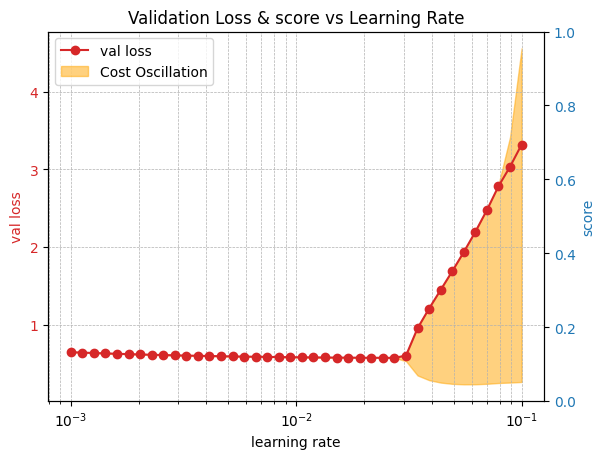

In [138]:
lrs = np.logspace(start=-3, stop=-1, num=40)
_ = plot_tools.lr_grid_search(X_train_np, y_train_np, X_val_np, y_val_np, lrs, class_weight=ratio, to_plot=True, iterations=200)

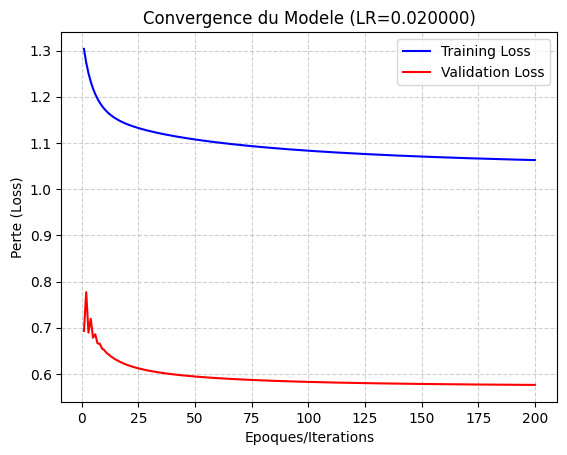

In [139]:
plot_tools.plot_convergence(X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=0.02, epochs_max=200, class_weight=ratio)

In [140]:
best_lr = 0.02
model_opt = feature_tracker.get_trained_model(learning_rate=best_lr, class_weight=ratio, threshold=model_opt.threshold, iterations=200)

Threshold   : 0.1000
[[   4 1091]
 [   0   70]]


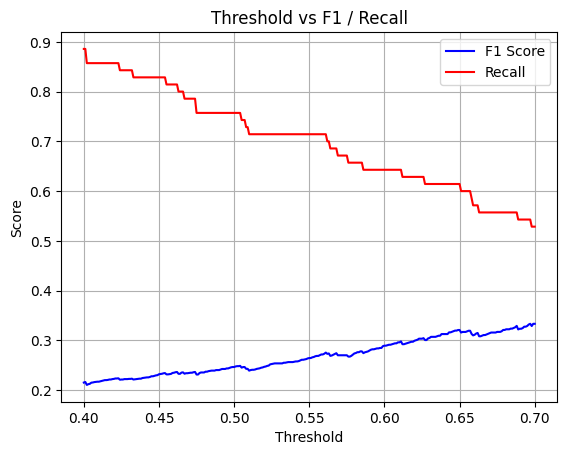

In [141]:
plot_tools.plot_threshold_metrics(model_opt, feature_tracker, range_min=0.4, range_max=0.7, step=0.001, plot_only_recall=False)

In [143]:
model_opt.threshold = 0.56
model_opt

Threshold   : 0.5600
[[849 246]
 [ 20  50]]

L2 reg sans les variables retirés

In [ ]:
#lambdas = np.logspace(-6, 1, 5)
# lambdas = np.arange(0, 110, 10)
#lambdas = np.arange(100, 2100, 100)
lambdas = np.arange(300, 500, 20)
lambda_const = logisticRegression.find_best_lambda(lambdas, X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=best_lr, class_weight=ratio, best_thresh=model_opt.threshold, iterations=200, t_opt_by_f1=False)

lambda=300 | T=0.560 | F1=0.2898 | Recall=0.7286
lambda=320 | T=0.560 | F1=0.2898 | Recall=0.7286
lambda=340 | T=0.560 | F1=0.2946 | Recall=0.7429
lambda=360 | T=0.560 | F1=0.2955 | Recall=0.7429
lambda=380 | T=0.560 | F1=0.2994 | Recall=0.7571
lambda=400 | T=0.560 | F1=0.2994 | Recall=0.7571
lambda=420 | T=0.560 | F1=0.2994 | Recall=0.7571
lambda=440 | T=0.560 | F1=0.2994 | Recall=0.7571
lambda=460 | T=0.560 | F1=0.2994 | Recall=0.7571
lambda=480 | T=0.560 | F1=0.2986 | Recall=0.7571

Best lambda (F1): 380
Best threshold: 0.560
Best F1: 0.2994
Recall: 0.7571

Best lambda (Recall): 380
Best Recall : 0.7571
F1 : 0.2994


In [146]:
lambda_const = 380

In [147]:
model_opt = feature_tracker.get_trained_model(iterations=200, learning_rate=best_lr, class_weight=ratio, threshold=model_opt.threshold, l2_reg=True, lambda_const=lambda_const)

Threshold   : 0.5600
[[864 231]
 [ 17  53]]


In [148]:
config_model_opt = model_config.ModelConfig(
    threshold=model_opt.threshold,
    class_weight=ratio,
    learning_rate=best_lr,
    iterations=200,
    l2_reg=True,
    lambda_const=lambda_const
)
config_model_opt

ModelConfig(threshold=0.56, class_weight=np.float64(15.748201438848922), learning_rate=0.02, iterations=200, l2_reg=True, l1_reg=False, lambda_const=380)

In [149]:
model_opt = feature_tracker.get_trained_model(**config_model_opt.as_dict(), name="Model opt")

Threshold   : 0.5600
[[864 231]
 [ 17  53]]


In [150]:
feature_tracker.get_features_cols()

['total_life_health_policies',
 'is_PPERSAUT_6xMFALLEEN',
 'total_daily_vehicle_policies',
 'PPERSAUTx_is_PBRAND_3_4',
 'total_property_policies',
 'MINKGEM',
 'total_third_party_policies',
 'MINK123M',
 'MINK4575',
 'PPERSAUT_6xMKOOPKLA',
 'PPERSAUTxis_low_no_religion_area',
 'PPERSAUTxMHKOOP_geq_6',
 'total_leisure_vehicle_policies',
 'total_work_heavy_vehicle_policies',
 'MINK7512']

In [151]:
X_eval, y_eval = feature_tracker.make_split_eval_data(cols=model_opt.cols)
model_opt.X_eval = X_eval
model_opt.y_eval = y_eval

In [152]:
model_opt.top_k_eval_final()

115